In [117]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import shutil

from plotly.express import scatter_geo
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from xgboost import XGBClassifier

%matplotlib inline


In [2]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)


# Load Data

Load all XLSX files into one dataframe.

In [183]:
df = pd.DataFrame()

for file in os.listdir():
    if file.startswith('~') or file == 'Telco_customer_churn_population.xlsx' or file.endswith('ipynb') or file == 'Output' or file == '.DS_Store':
        # print('Ignoring', file)
        continue
    # print('Starting', file)
    if len(df) == 0:  # create a new dataframe if this is the first file
        df = pd.read_excel(file)
    else:
        # print(file)
        df_to_merge = pd.read_excel(file)
        cols_to_use = df_to_merge.columns.difference(
            df.columns).tolist()  # only the different columns
        cols_to_use.append('Customer ID')  # append this for merging
        # print(cols_to_use)
        df = df.merge(df_to_merge[cols_to_use],
                      on='Customer ID', suffixes=(None, None))

# Add the populations to this dataframe.
df = df.merge(pd.read_excel('Telco_customer_churn_population.xlsx'),
              left_on='Zip Code', right_on='Zip Code')


## Data Description

In [4]:
df


Customer ID  Count        Country       State            City  Zip Code  \
0     3668-QPYBK      1  United States  California     Los Angeles     90003   
1     2967-MXRAV      1  United States  California     Los Angeles     90003   
2     9643-AVVWI      1  United States  California     Los Angeles     90003   
3     0060-FUALY      1  United States  California     Los Angeles     90003   
4     9696-RMYBA      1  United States  California     Los Angeles     90003   
...          ...    ...            ...         ...             ...       ...   
7038  0083-PIVIK      1  United States  California        Tulelake     96134   
7039  7426-WEIJX      1  United States  California  Olympic Valley     96146   
7040  1403-LKLIK      1  United States  California  Olympic Valley     96146   
7041  7379-FNIUJ      1  United States  California  Olympic Valley     96146   
7042  7729-JTEEC      1  United States  California  Olympic Valley     96146   

                    Lat Long   Latitude   Longitude  Gender Senior Citizen  \
0     33.964131, -118.272783  33.964131 -118.272783    Male             No   
1     33.964131, -118.272783  33.964131 -118.272783    Male             No   
2     33.964131, -118.272783  33.964131 -118.272783  Female             No   
3     33.964131, -118.272783  33.964131 -118.272783  Female             No   
4     33.964131, -118.272783  33.964131 -118.272783    Male             No   
...                      ...        ...         ...     ...            ...   
7038  41.813521, -121.492666  41.813521 -121.492666    Male             No   
7039  39.191797, -120.212401  39.191797 -120.212401    Male            Yes   
7040  39.191797, -120.212401  39.191797 -120.212401  Female             No   
7041  39.191797, -120.212401  39.191797 -120.212401    Male             No   
7042  39.191797, -120.212401  39.191797 -120.212401    Male             No   

     Partner Dependents  Tenure Months Phone Service Multiple Lines  \
0         No         No              2           Yes             No   
1        Yes         No              1           Yes             No   
2        Yes        Yes              3           Yes             No   
3        Yes         No             59           Yes            Yes   
4         No         No              5           Yes             No   
...      ...        ...            ...           ...            ...   
7038      No         No             64           Yes            Yes   
7039     Yes        Yes             60           Yes            Yes   
7040     Yes        Yes             33           Yes             No   
7041      No         No              2           Yes             No   
7042     Yes        Yes              2           Yes             No   

     Internet Service      Online Security        Online Backup  \
0                 DSL                  Yes                  Yes   
1                  No  No internet service  No internet service   
2         Fiber optic                   No                  Yes   
3         Fiber optic                  Yes                  Yes   
4         Fiber optic                   No                   No   
...               ...                  ...                  ...   
7038              DSL                  Yes                  Yes   
7039      Fiber optic                  Yes                   No   
7040               No  No internet service  No internet service   
7041      Fiber optic                  Yes                  Yes   
7042              DSL                   No                   No   

        Device Protection         Tech Support         Streaming TV  \
0                      No                   No                   No   
1     No internet service  No internet service  No internet service   
2                      No                  Yes                   No   
3                      No                   No                  Yes   
4                      No                   No                  Yes   
...                   .

In [5]:
if not os.path.isdir('Output'):
    os.mkdir('Output')

outfile = 'Full Telco Customer Churn.xlsx'
df.to_excel(outfile)

shutil.move(outfile, 'Output/' + outfile)


'Output/Full Telco Customer Churn.xlsx'

In [6]:
df.describe(include='all')


Customer ID   Count        Country       State         City  \
count         7043  7043.0           7043        7043         7043   
unique        7043     NaN              1           1         1129   
top     3668-QPYBK     NaN  United States  California  Los Angeles   
freq             1     NaN           7043        7043          305   
mean           NaN     1.0            NaN         NaN          NaN   
std            NaN     0.0            NaN         NaN          NaN   
min            NaN     1.0            NaN         NaN          NaN   
25%            NaN     1.0            NaN         NaN          NaN   
50%            NaN     1.0            NaN         NaN          NaN   
75%            NaN     1.0            NaN         NaN          NaN   
max            NaN     1.0            NaN         NaN          NaN   

            Zip Code                Lat Long     Latitude    Longitude Gender  \
count    7043.000000                    7043  7043.000000  7043.000000   7043   
unique           NaN                    1652          NaN          NaN      2   
top              NaN  33.964131, -118.272783          NaN          NaN   Male   
freq             NaN                       5          NaN          NaN   3555   
mean    93521.964646                     NaN    36.282441  -119.798880    NaN   
std      1865.794555                     NaN     2.455723     2.157889    NaN   
min     90001.000000                     NaN    32.555828  -124.301372    NaN   
25%     92102.000000                     NaN    34.030915  -121.815412    NaN   
50%     93552.000000                     NaN    36.391777  -119.730885    NaN   
75%     95351.000000                     NaN    38.224869  -118.043237    NaN   
max     96161.000000                     NaN    41.962127  -114.192901    NaN   

       Senior Citizen Partner Dependents  Tenure Months Phone Service  \
count            7043    7043       7043    7043.000000          7043   
unique              2       2          2            NaN             2   
top                No      No         No            NaN           Yes   
freq             5901    3641       5416            NaN          6361   
mean              NaN     NaN        NaN      32.371149           NaN   
std               NaN     NaN        NaN      24.559481           NaN   
min               NaN     NaN        NaN       0.000000           NaN   
25%               NaN     NaN        NaN       9.000000           NaN   
50%               NaN     NaN        NaN      29.000000           NaN   
75%               NaN     NaN        NaN      55.000000           NaN   
max               NaN     NaN        NaN      72.000000           NaN   

       Multiple Lines Internet Service Online Security Online Backup  \
count            7043             7043            7043          7043   
unique              3                3               3             3   
top                No      Fiber optic              No            No   
freq             3390             3096            3498          3088   
mean              NaN              NaN             NaN           NaN   
std               NaN              NaN             NaN           NaN   
min               NaN              NaN             NaN           NaN   
25%               NaN              NaN             NaN           NaN   
50%               NaN              NaN             NaN           NaN   
75%               NaN              NaN             NaN           NaN   
max               NaN              NaN             NaN           NaN   

       Device Protection Tech Support Streaming TV Streaming Movies  \
count               7043         7043         7043             7043   
unique                 3            3            3                3   
top                   No           No           No               No   
freq                3095         3473         2810             2785   
mean                 NaN          NaN          NaN              NaN   
std                  NaN 

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Country                            7043 non-null   object 
 3   State                              7043 non-null   object 
 4   City                               7043 non-null   object 
 5   Zip Code                           7043 non-null   int64  
 6   Lat Long                           7043 non-null   object 
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Gender                             7043 non-null   object 
 10  Senior Citizen                     7043 non-null   object 
 11  Partner                            7043 non-null   objec

Only "Churn Reason" and "Churn Category" have null values.

In [8]:
df['Churn Reason'].value_counts()  # 20 reasons


Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Long distance charges                         44
Limited range of services                     44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

In [9]:
df['Churn Category'].value_counts()  # 5 categories


Competitor         841
Attitude           314
Dissatisfaction    303
Price              211
Other              200
Name: Churn Category, Length: 5, dtype: int64

# EDA

## Location Plotting

In [10]:
sg = scatter_geo(df, df['Latitude'], df['Longitude'],
                 hover_data=['City', 'Monthly Charges'], fitbounds='locations',
                 title='Monthly Charges per Customer', template='ggplot2')
sg.show()


## Corrolation Mapping

In [ ]:
# to be added

## Statistical Analysis

### Overall Customers

#### Customer Demographics

Text(0.5, 1.0, 'Number of Customers Under 30')

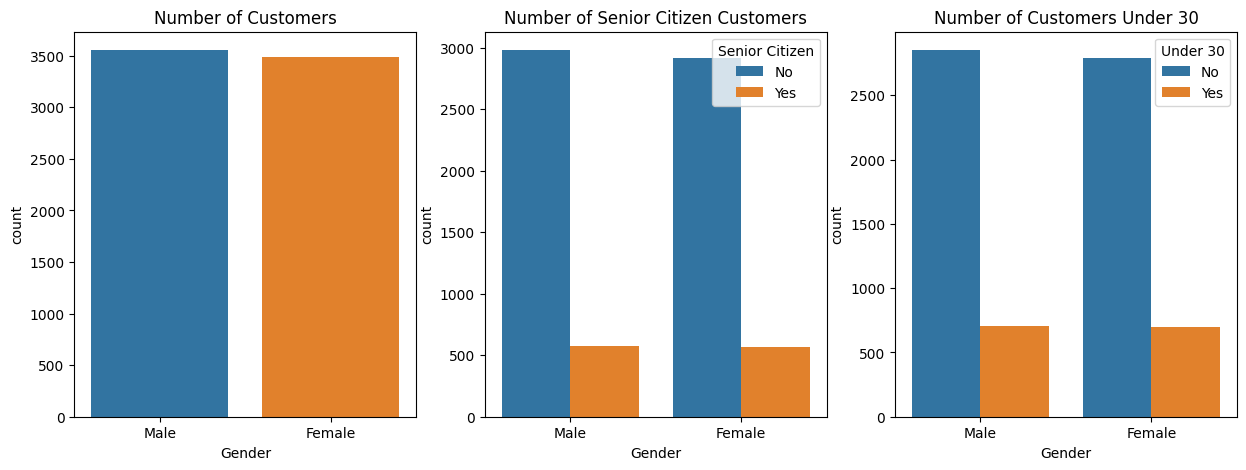

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = sns.countplot(df, x='Gender', ax=axes[0])
ax.set_title('Number of Customers')

ax = sns.countplot(df, x='Gender', hue='Senior Citizen', ax=axes[1])
ax.set_title('Number of Senior Citizen Customers')

ax = sns.countplot(df, x='Gender', hue='Under 30', ax=axes[2])
ax.set_title('Number of Customers Under 30')


#### Phone Services

Text(0.5, 1.0, 'Number of Customers with the Phone Service')

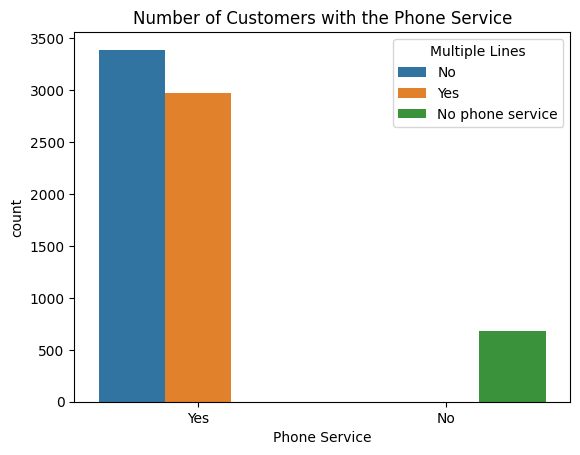

In [12]:
ax = sns.countplot(df, x='Phone Service', hue='Multiple Lines')
ax.set_title('Number of Customers with the Phone Service')


#### Internet Services

Text(0.5, 1.0, 'Number of Internet Customers with Premium Tech Support')

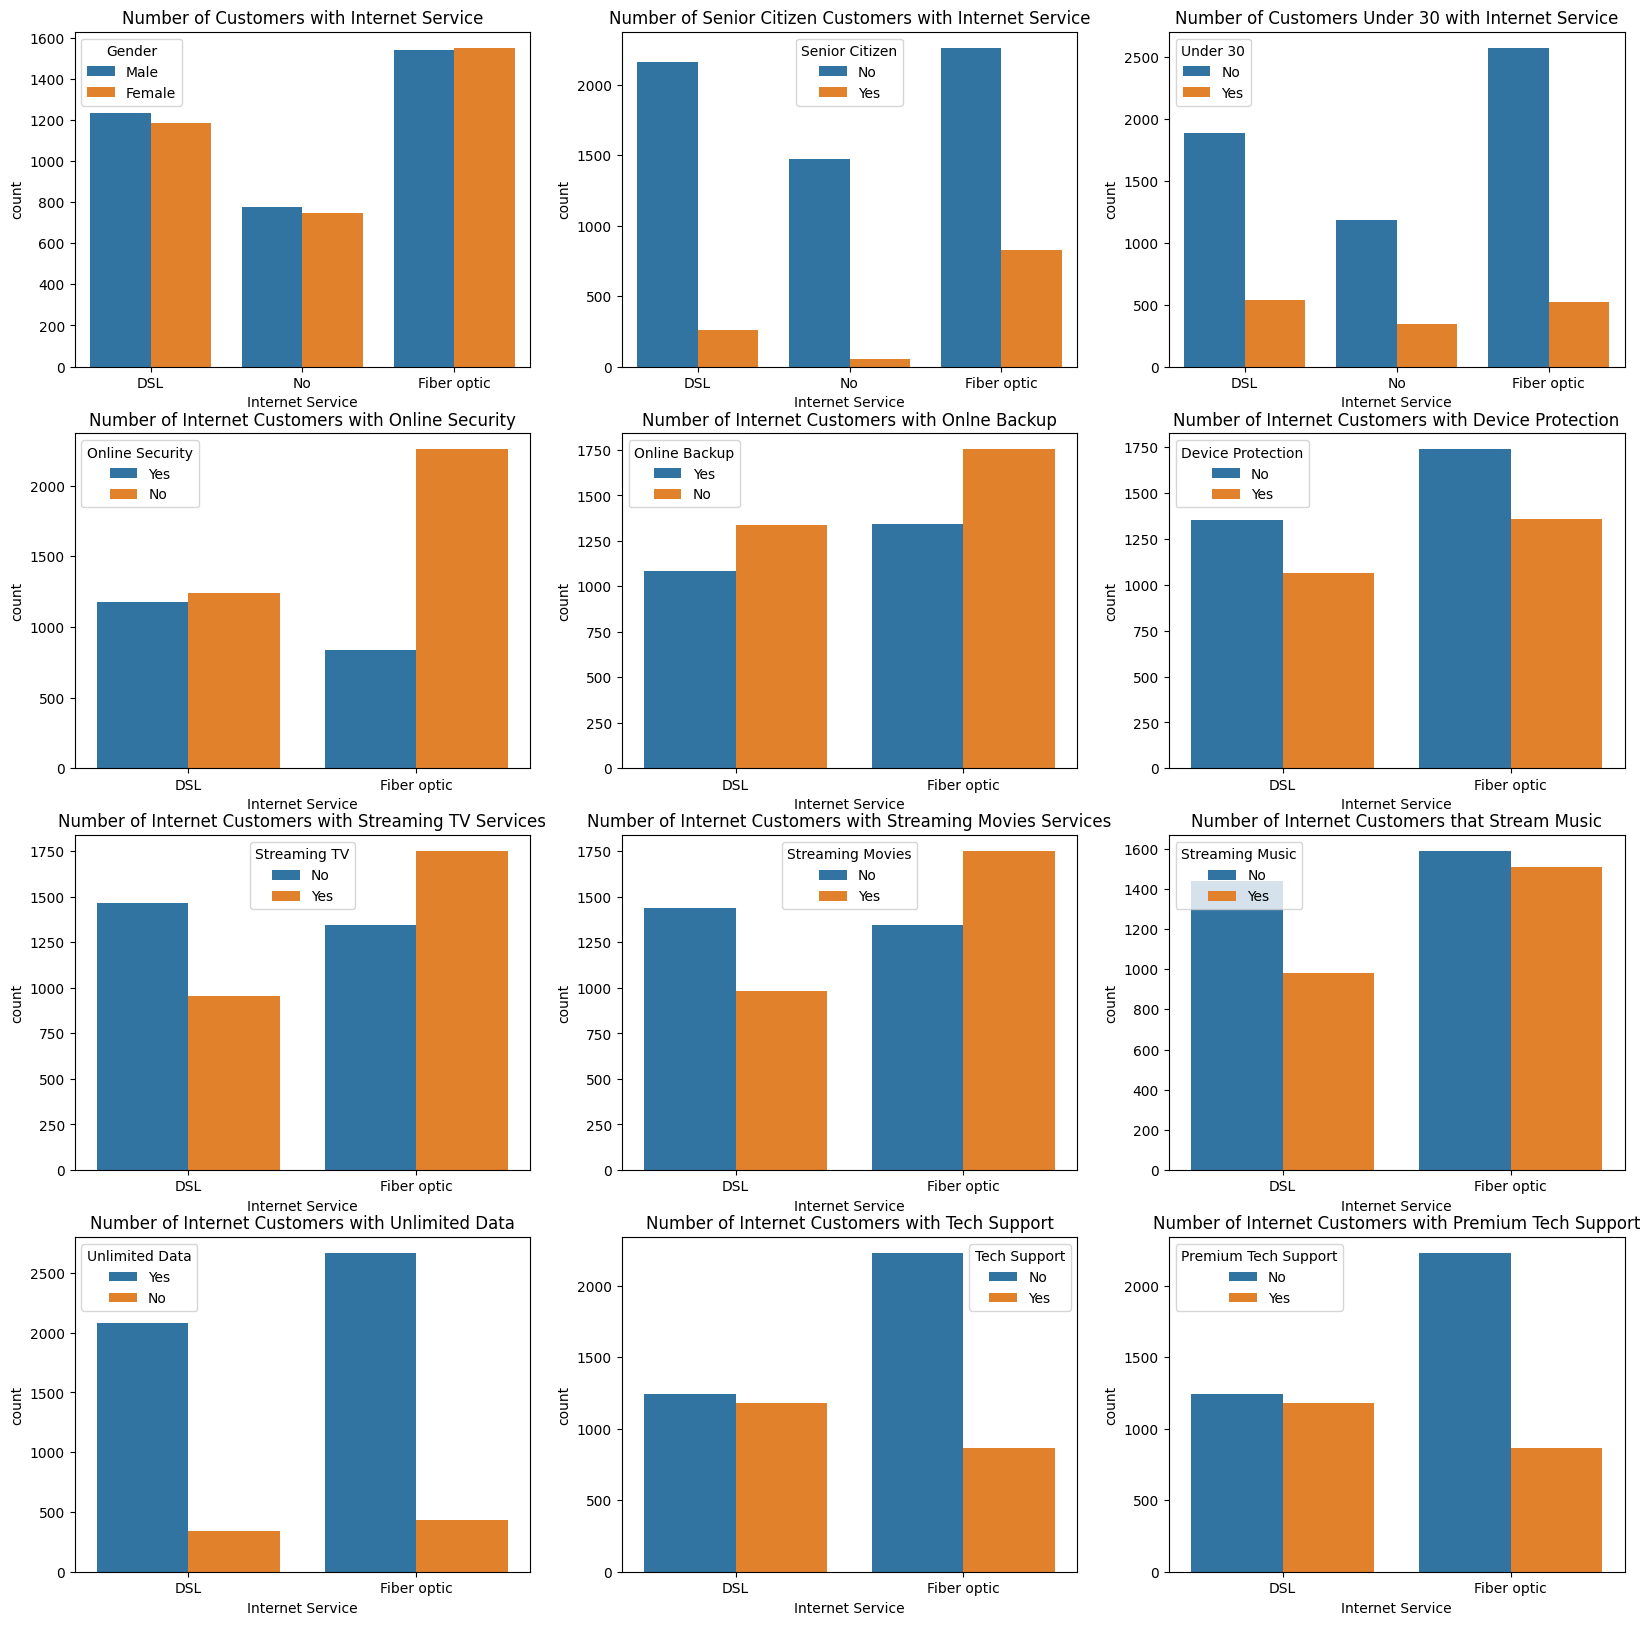

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# demographics split
ax = sns.countplot(df, x='Internet Service', hue='Gender', ax=axes[0, 0])
ax.set_title('Number of Customers with Internet Service')

ax = sns.countplot(df, x='Internet Service',
                   hue='Senior Citizen', ax=axes[0, 1])
ax.set_title('Number of Senior Citizen Customers with Internet Service')

ax = sns.countplot(df, x='Internet Service', hue='Under 30', ax=axes[0, 2])
ax.set_title('Number of Customers Under 30 with Internet Service')

# security and backup split
ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Online Security', ax=axes[1, 0])
ax.set_title('Number of Internet Customers with Online Security')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Online Backup', ax=axes[1, 1])
ax.set_title('Number of Internet Customers with Onlne Backup')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Device Protection', ax=axes[1, 2])
ax.set_title('Number of Internet Customers with Device Protection')

# streaming services split
ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Streaming TV', ax=axes[2, 0])
ax.set_title('Number of Internet Customers with Streaming TV Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Streaming Movies', ax=axes[2, 1])
ax.set_title('Number of Internet Customers with Streaming Movies Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Streaming Music', ax=axes[2, 2])
ax.set_title('Number of Internet Customers that Stream Music')

# unlimited data and tech support split
ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Unlimited Data', ax=axes[3, 0])
ax.set_title('Number of Internet Customers with Unlimited Data')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Tech Support', ax=axes[3, 1])
ax.set_title('Number of Internet Customers with Tech Support')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Premium Tech Support', ax=axes[3, 2])
ax.set_title('Number of Internet Customers with Premium Tech Support')


#### Customer Tenure

Text(0.5, 1.0, 'Number of Customers Churned/Stayed/Joined vs Tenure in Months')

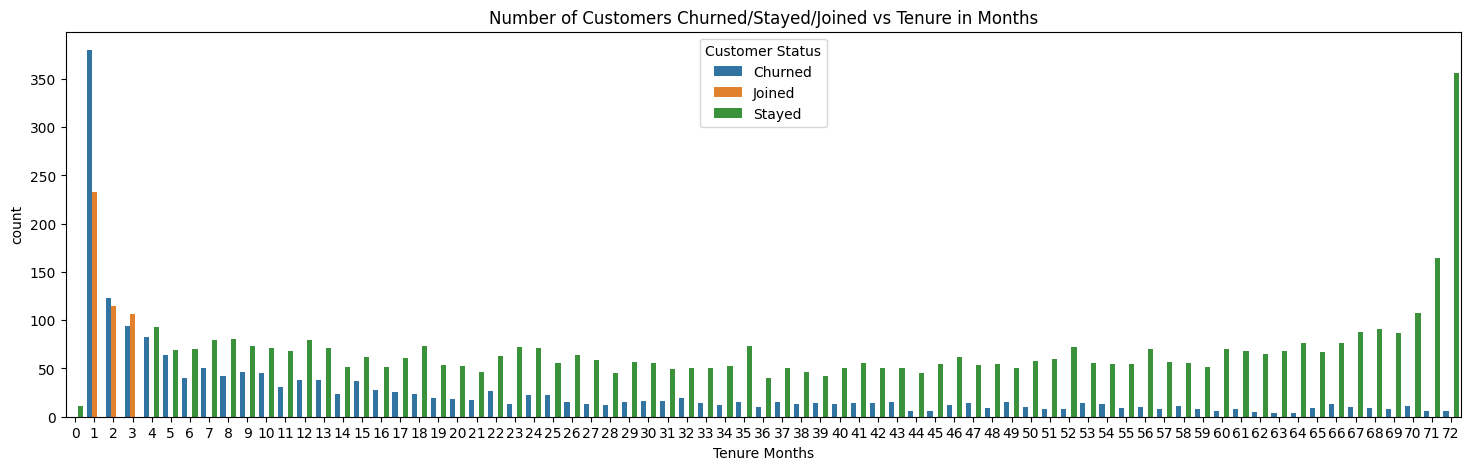

In [14]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df, x='Tenure Months', hue='Customer Status')
ax.set_title('Number of Customers Churned/Stayed/Joined vs Tenure in Months')


Text(0.5, 1.0, "Density of Customers' Status")

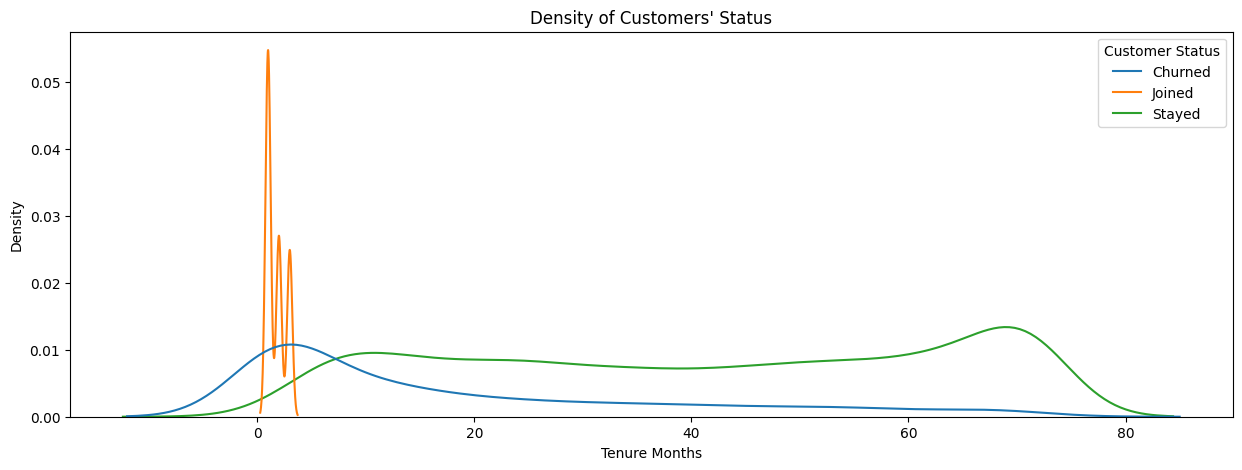

In [15]:
fig, axes = plt.subplots(figsize=(15, 5))
ax = sns.kdeplot(df, x='Tenure Months', hue='Customer Status')
ax.set_title('Density of Customers\' Status')


Text(0.5, 1.0, 'Number of Customers with Phone Service vs Tenure in Months')

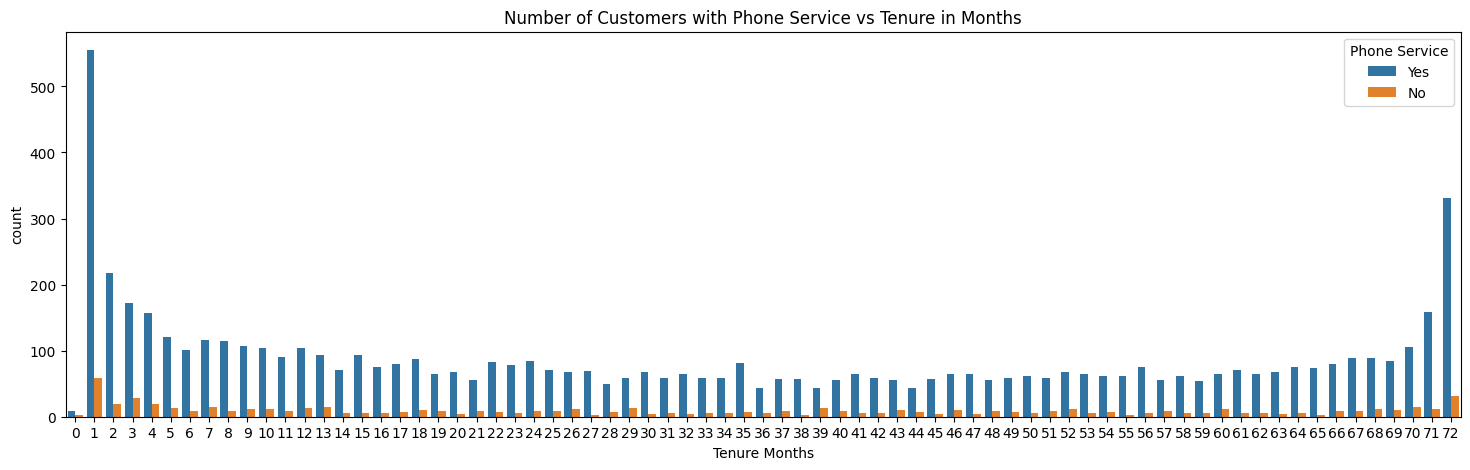

In [16]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df, x='Tenure Months', hue='Phone Service')
ax.set_title('Number of Customers with Phone Service vs Tenure in Months')


Text(0.5, 1.0, 'Number of Customers with Internet Service vs Tenure in Months')

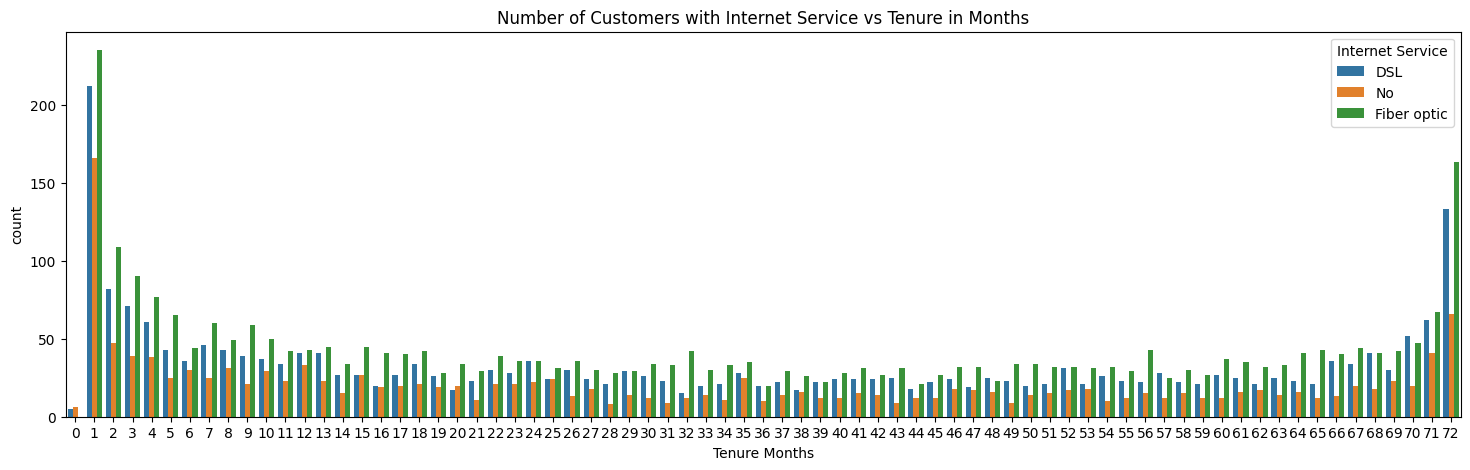

In [17]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df, x='Tenure Months', hue='Internet Service')
ax.set_title('Number of Customers with Internet Service vs Tenure in Months')


Text(0.5, 1.0, 'Trend of Long Distance Charges over the months')

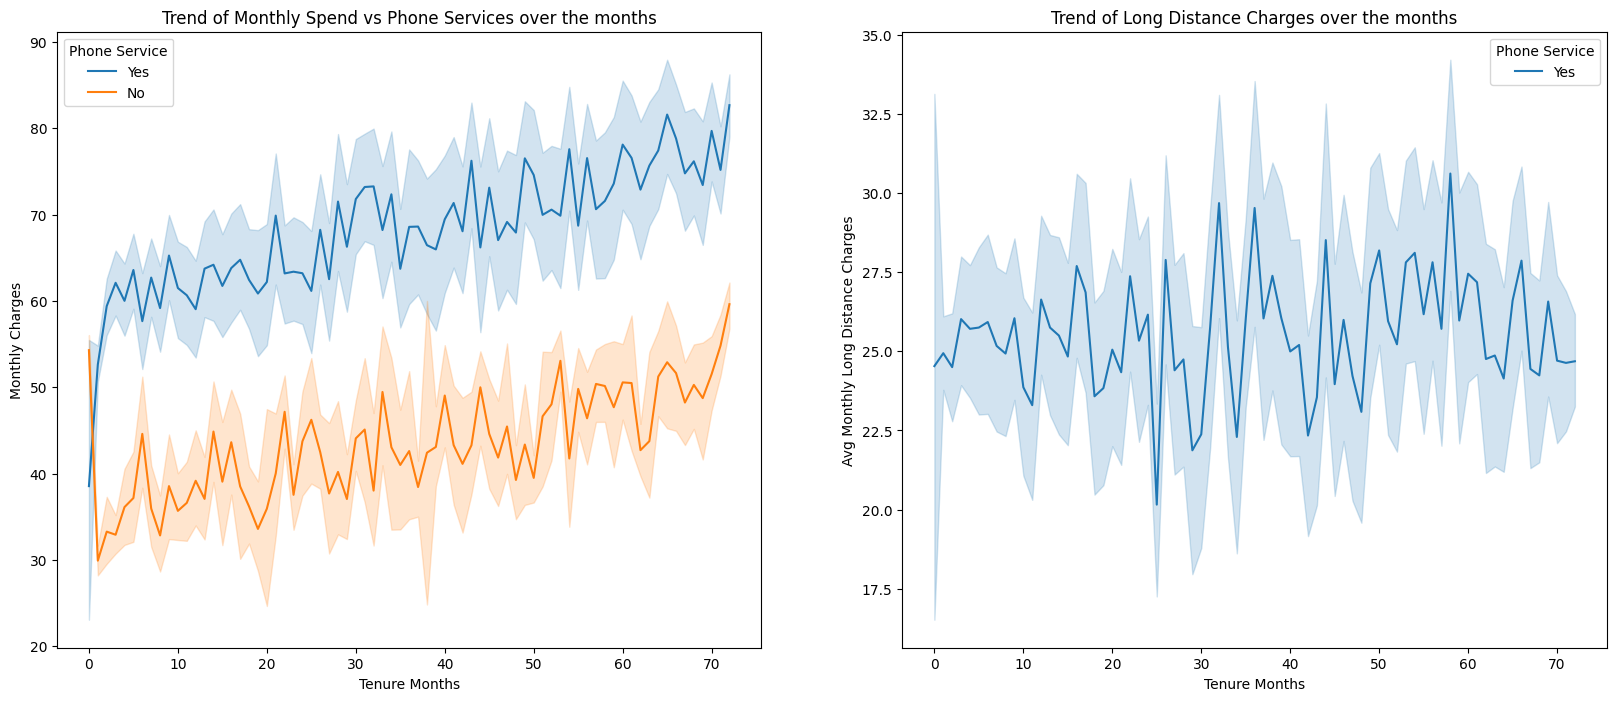

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months', y='Monthly Charges',
                  hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Phone Services over the months')

ax = sns.lineplot(df[(df['Phone Service'] == 'Yes')], x='Tenure Months',
                  y='Avg Monthly Long Distance Charges', hue='Phone Service', ax=axes[1])
ax.set_title('Trend of Long Distance Charges over the months')


Text(0.5, 1.0, 'Trend of Avg Monthly GB Downloads over the months')

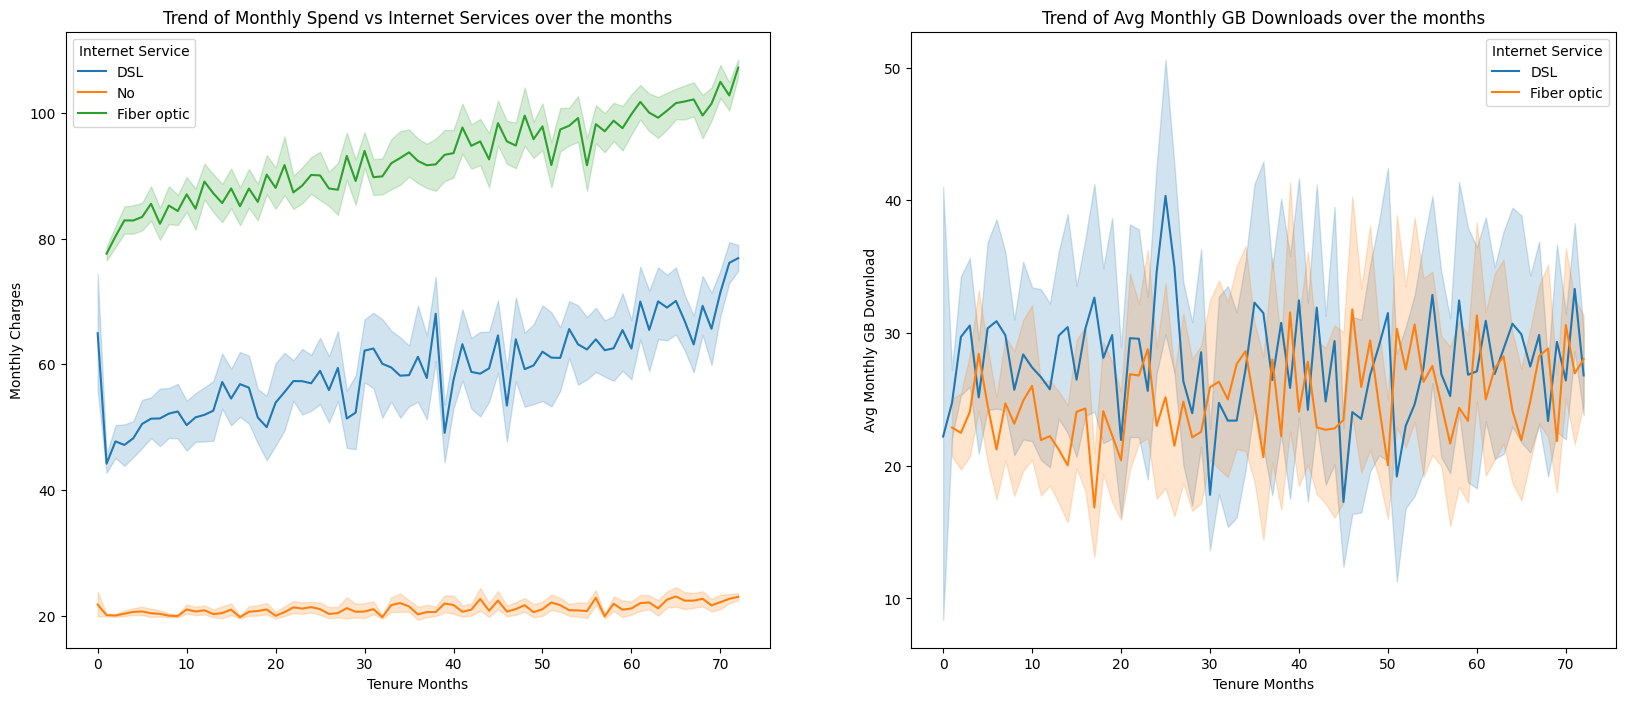

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months', y='Monthly Charges',
                  hue='Internet Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Internet Services over the months')

ax = sns.lineplot(df[(df['Internet Service'] != 'No')], x='Tenure Months',
                  y='Avg Monthly GB Download', hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Avg Monthly GB Downloads over the months')


Text(0.5, 1.0, 'Trend of Total Spend vs Internet Services over the months')

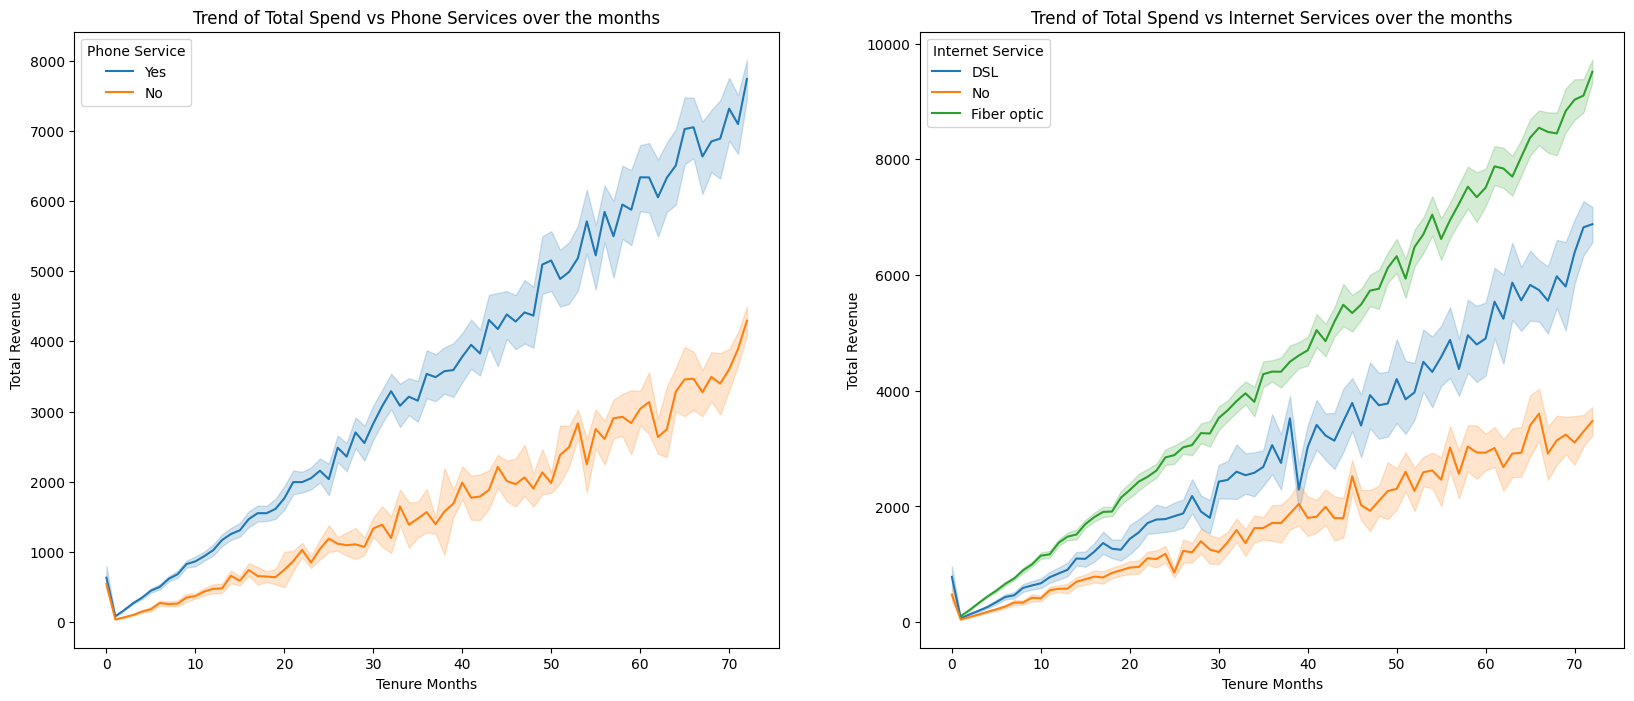

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months', y='Total Revenue',
                  hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Total Spend vs Phone Services over the months')

ax = sns.lineplot(df, x='Tenure Months', y='Total Revenue',
                  hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Total Spend vs Internet Services over the months')


Text(0.5, 1.0, 'Trend of Total Extra Data Charges vs Internet Services over the months')

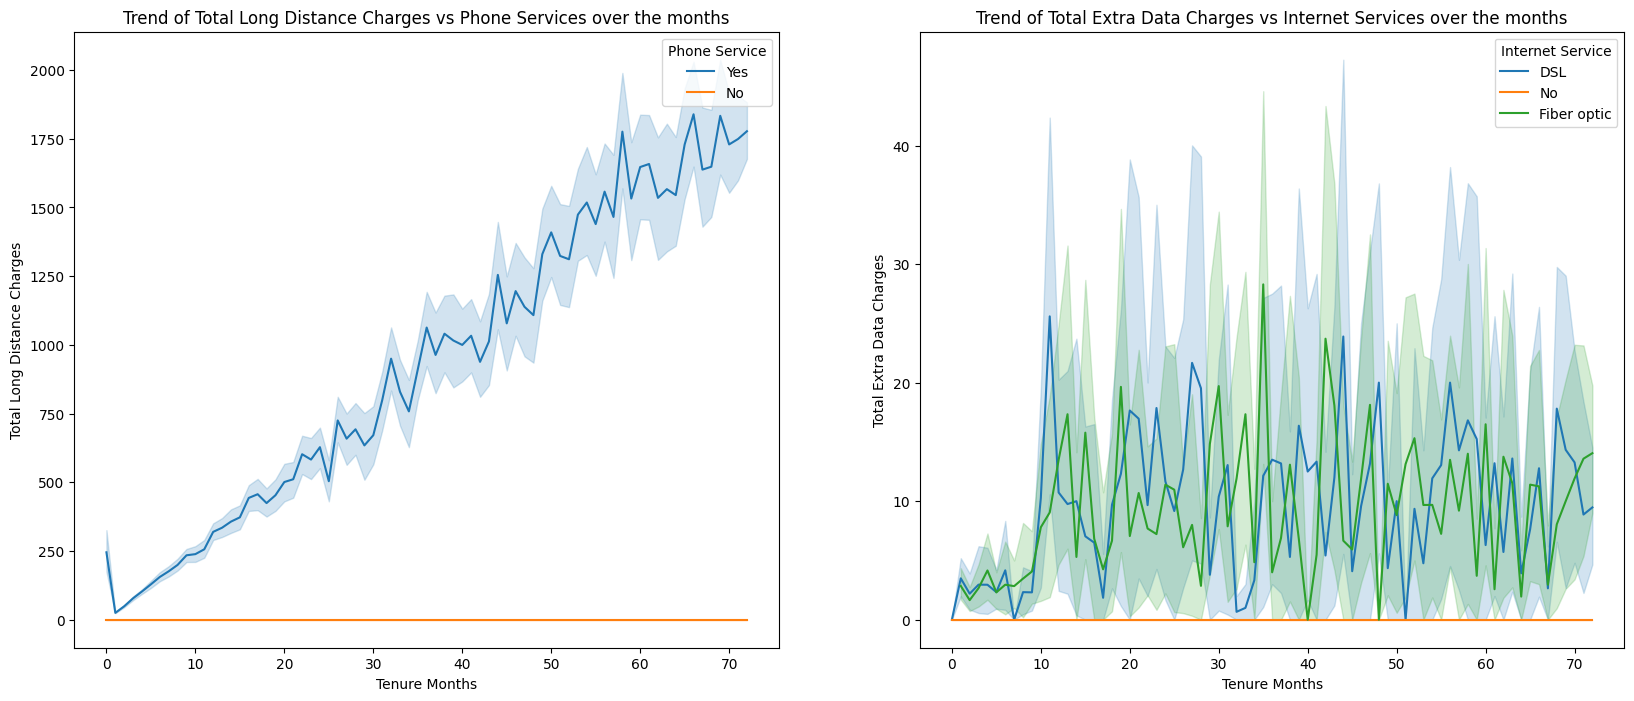

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months',
                  y='Total Long Distance Charges', hue='Phone Service', ax=axes[0])
ax.set_title(
    'Trend of Total Long Distance Charges vs Phone Services over the months')

ax = sns.lineplot(df, x='Tenure Months', y='Total Extra Data Charges',
                  hue='Internet Service', ax=axes[1])
ax.set_title(
    'Trend of Total Extra Data Charges vs Internet Services over the months')


Text(0.5, 1.0, 'Avg Monthly GB Download over the Months vs Customer Status')

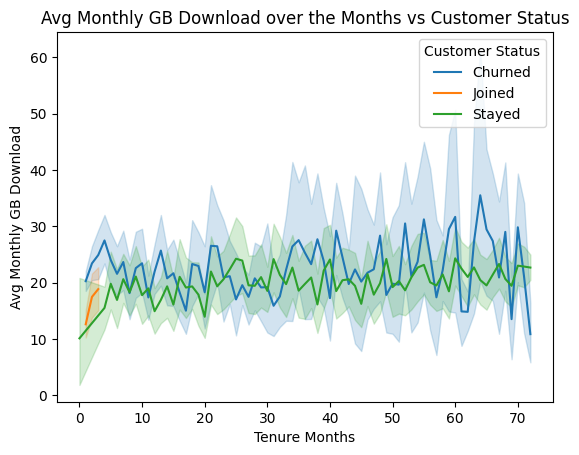

In [22]:
ax = sns.lineplot(df, x='Tenure Months',
                  y='Avg Monthly GB Download', hue='Customer Status')
ax.set_title('Avg Monthly GB Download over the Months vs Customer Status')


Text(0.5, 1.0, 'Total Refunds over the Months vs Customer Status')

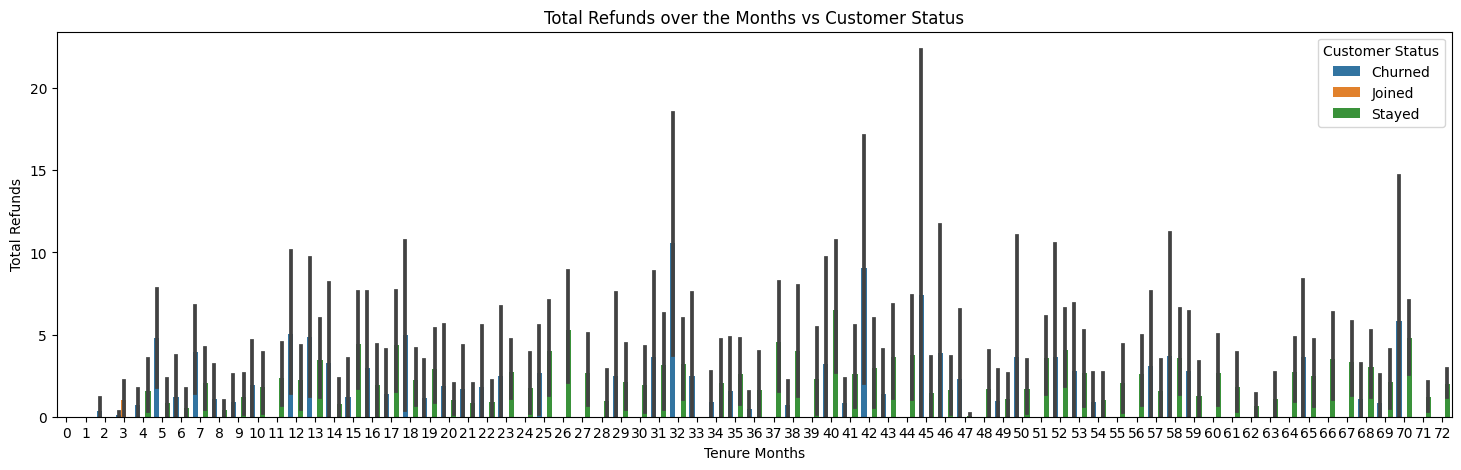

In [23]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.barplot(df, x='Tenure Months',
                 y='Total Refunds', hue='Customer Status')
ax.set_title('Total Refunds over the Months vs Customer Status')


Text(0.5, 1.0, 'Number of used offers per Customer Status')

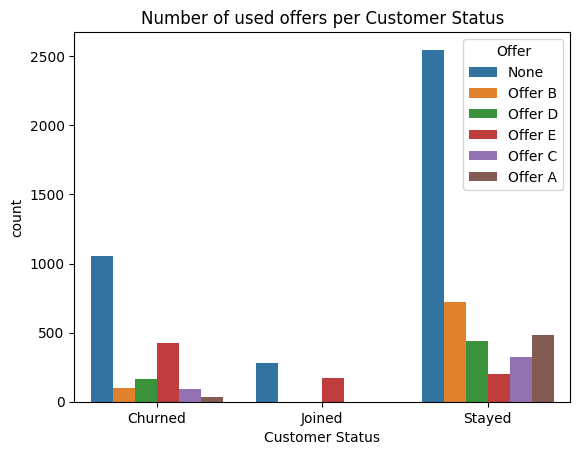

In [24]:
ax = sns.countplot(df, x='Customer Status', hue='Offer')
ax.set_title('Number of used offers per Customer Status')


Text(0.5, 1.0, 'Friend Referral per Customer Status')

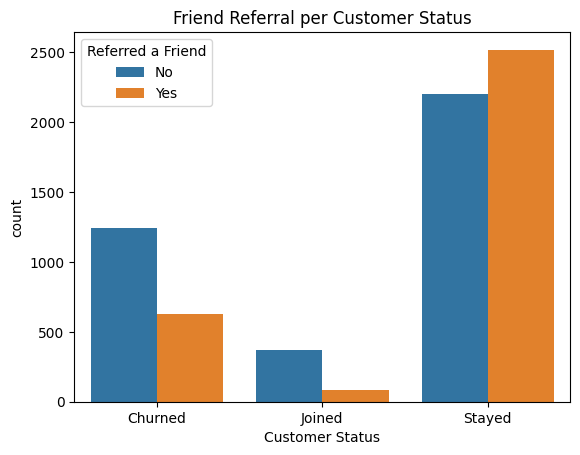

In [25]:
ax = sns.countplot(df, x='Customer Status', hue='Referred a Friend')
ax.set_title('Friend Referral per Customer Status')


<AxesSubplot: xlabel='Gender', ylabel='Avg Monthly GB Download'>

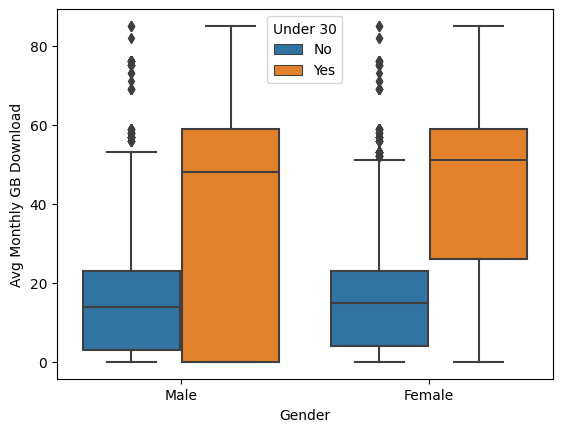

In [26]:
sns.boxplot(df, x='Gender', y='Avg Monthly GB Download', hue='Under 30')


### Churned Customers

#### Customer Demographics

Text(0.5, 1.0, 'Number of Customers Under 30')

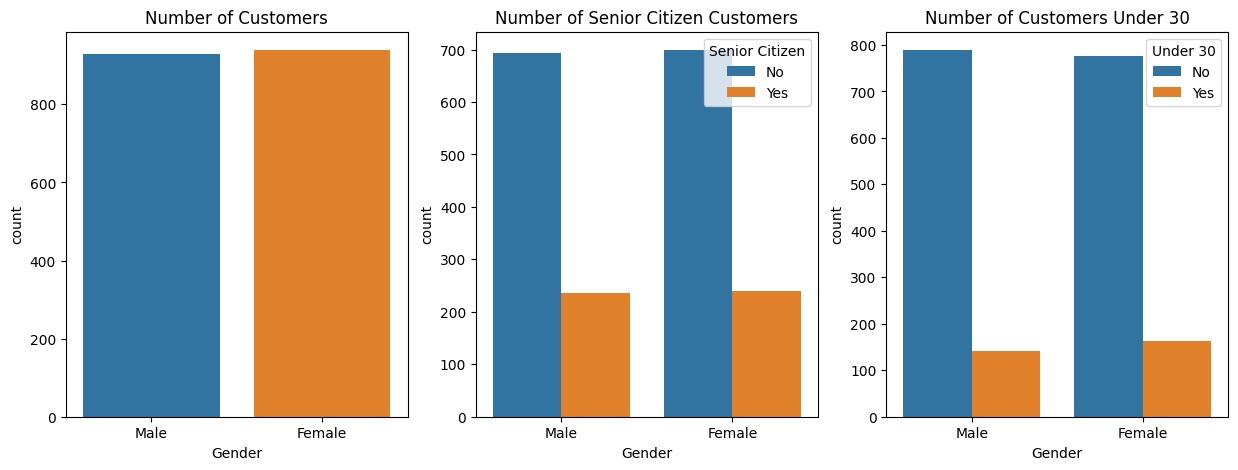

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')], x='Gender', ax=axes[0])
ax.set_title('Number of Customers')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Gender', hue='Senior Citizen', ax=axes[1])
ax.set_title('Number of Senior Citizen Customers')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Gender', hue='Under 30', ax=axes[2])
ax.set_title('Number of Customers Under 30')


#### Phone Services

Text(0.5, 1.0, 'Number of Customers with the Phone Service')

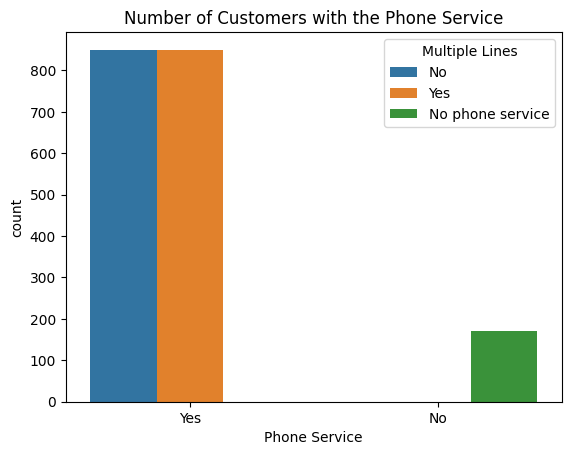

In [28]:
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Phone Service', hue='Multiple Lines')
ax.set_title('Number of Customers with the Phone Service')


#### Internet Services

Text(0.5, 1.0, 'Number of Internet Customers with Premium Tech Support')

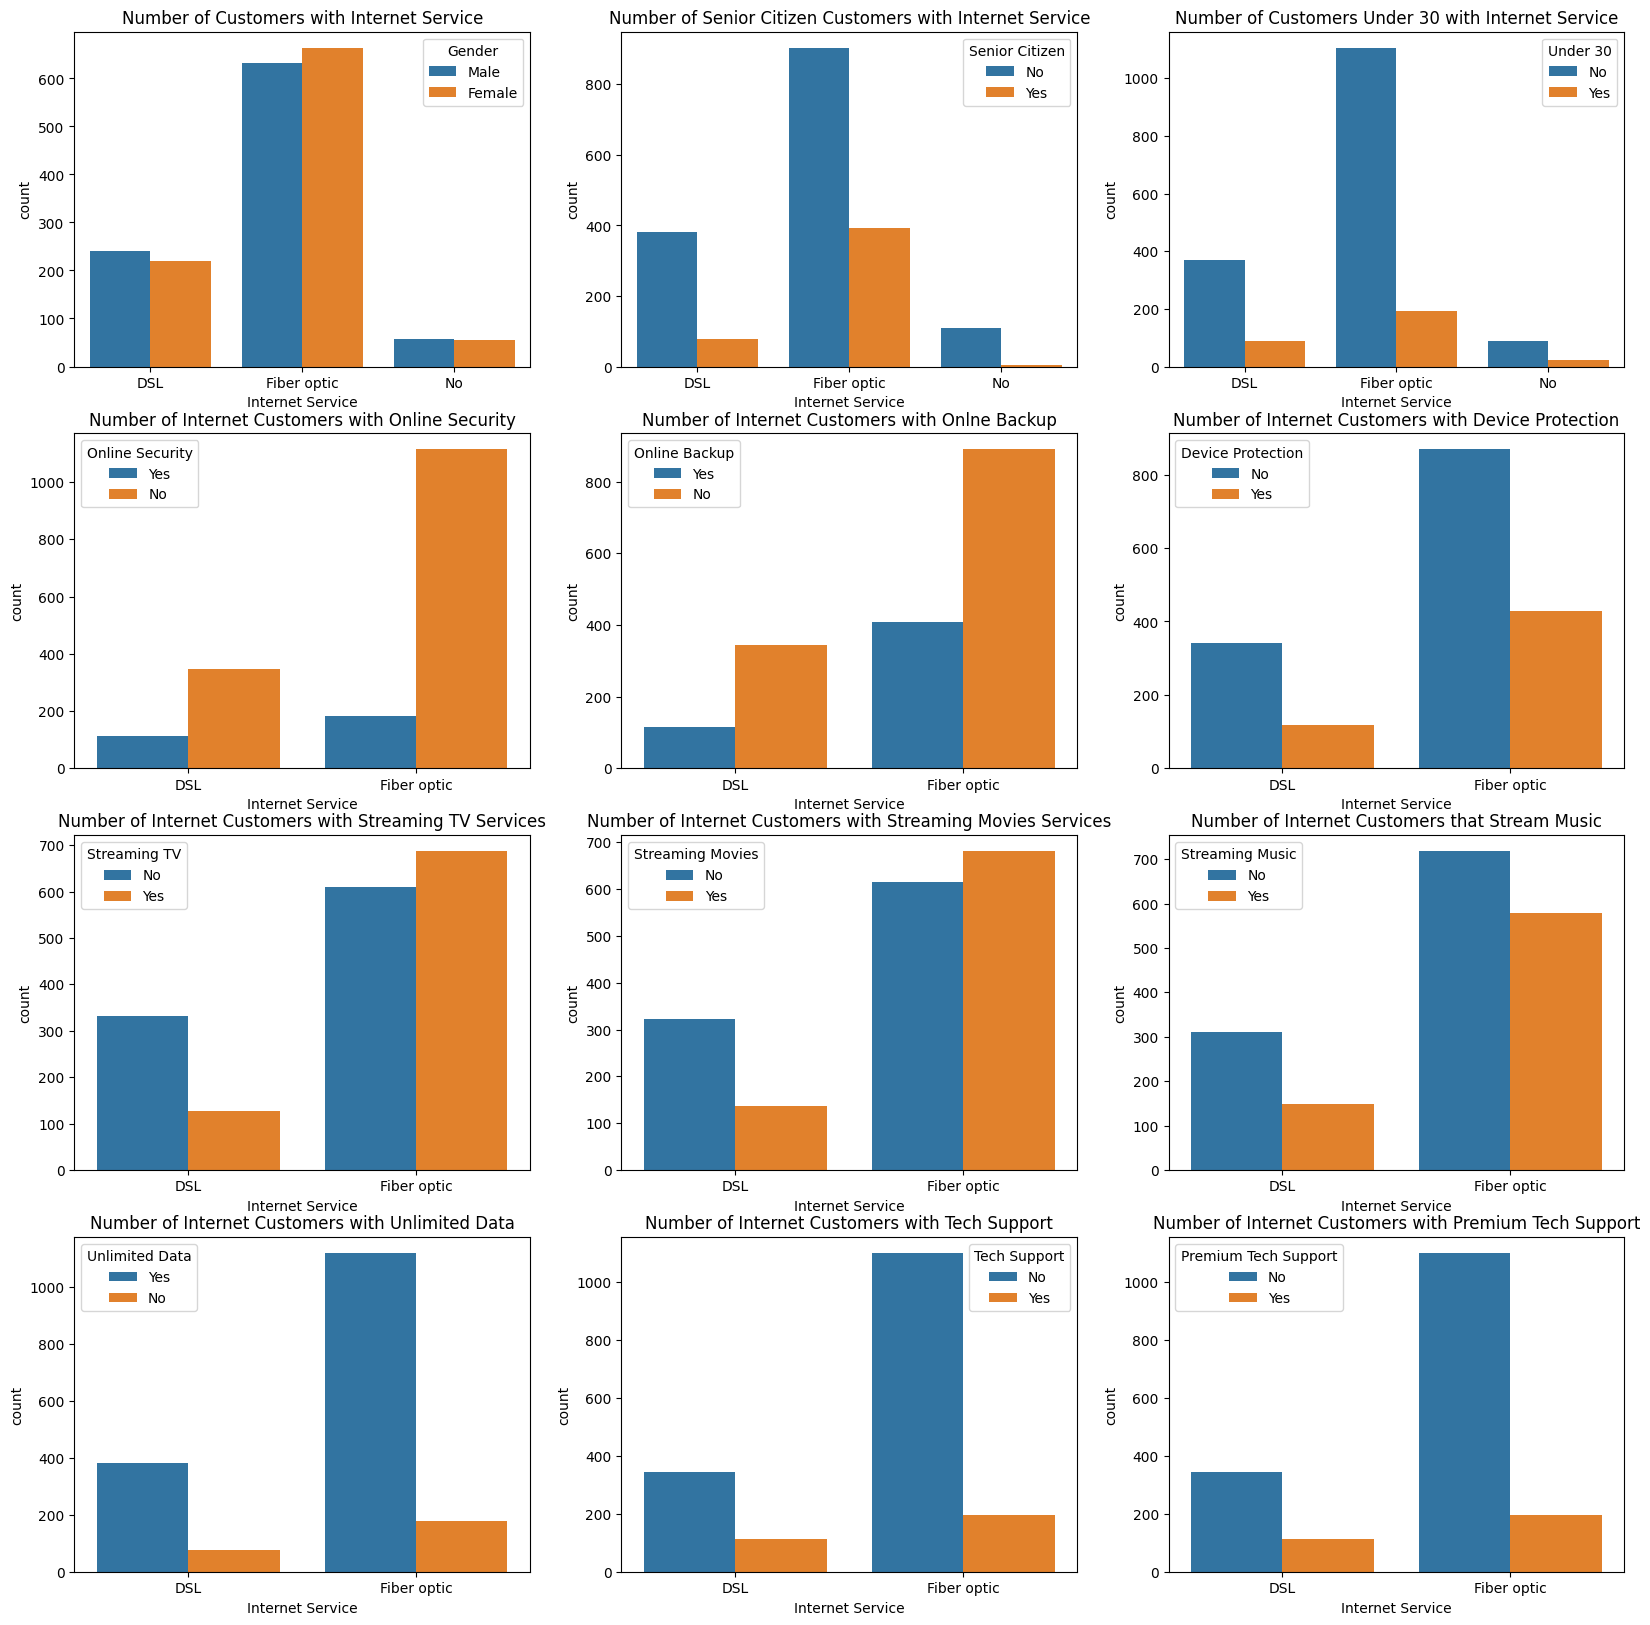

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# demographics split
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Gender', ax=axes[0, 0])
ax.set_title('Number of Customers with Internet Service')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')], x='Internet Service',
                   hue='Senior Citizen', ax=axes[0, 1])
ax.set_title('Number of Senior Citizen Customers with Internet Service')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Under 30', ax=axes[0, 2])
ax.set_title('Number of Customers Under 30 with Internet Service')

# security and backup split
ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Online Security', ax=axes[1, 0])
ax.set_title('Number of Internet Customers with Online Security')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Online Backup', ax=axes[1, 1])
ax.set_title('Number of Internet Customers with Onlne Backup')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Device Protection', ax=axes[1, 2])
ax.set_title('Number of Internet Customers with Device Protection')

# streaming services split
ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Streaming TV', ax=axes[2, 0])
ax.set_title('Number of Internet Customers with Streaming TV Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Streaming Movies', ax=axes[2, 1])
ax.set_title('Number of Internet Customers with Streaming Movies Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Streaming Music', ax=axes[2, 2])
ax.set_title('Number of Internet Customers that Stream Music')

# unlimited data and tech support split
ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Unlimited Data', ax=axes[3, 0])
ax.set_title('Number of Internet Customers with Unlimited Data')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Tech Support', ax=axes[3, 1])
ax.set_title('Number of Internet Customers with Tech Support')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Premium Tech Support', ax=axes[3, 2])
ax.set_title('Number of Internet Customers with Premium Tech Support')


#### Customer Tenure

Text(0.5, 1.0, 'Number of Customers Churned vs Tenure in Months')

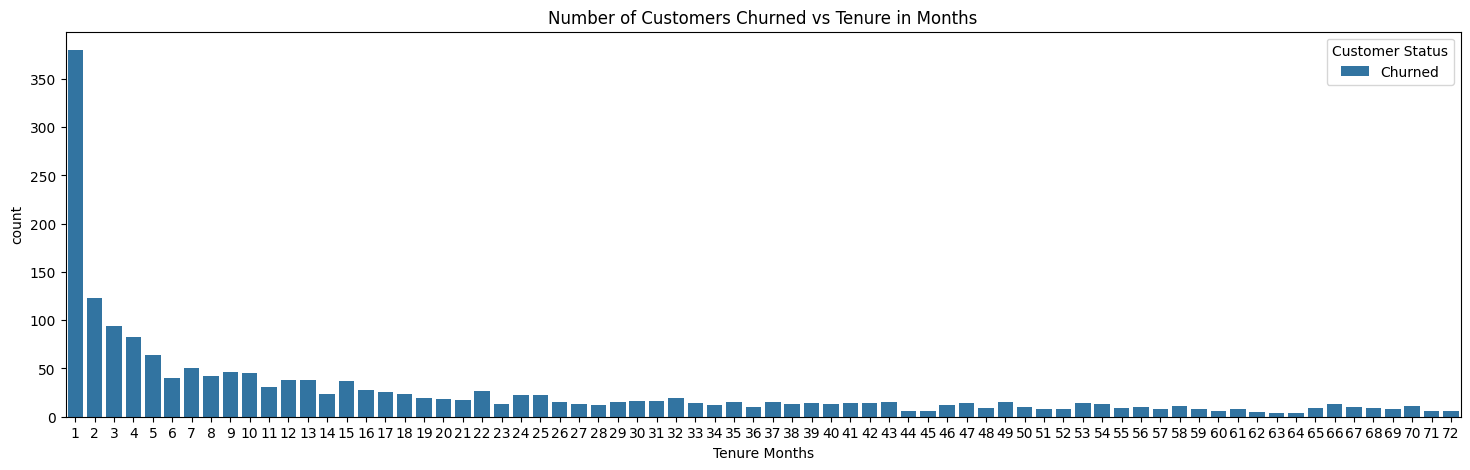

In [30]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Tenure Months', hue='Customer Status')
ax.set_title('Number of Customers Churned vs Tenure in Months')


Text(0.5, 1.0, 'Density of Customers Churned over their Tenure (months)')

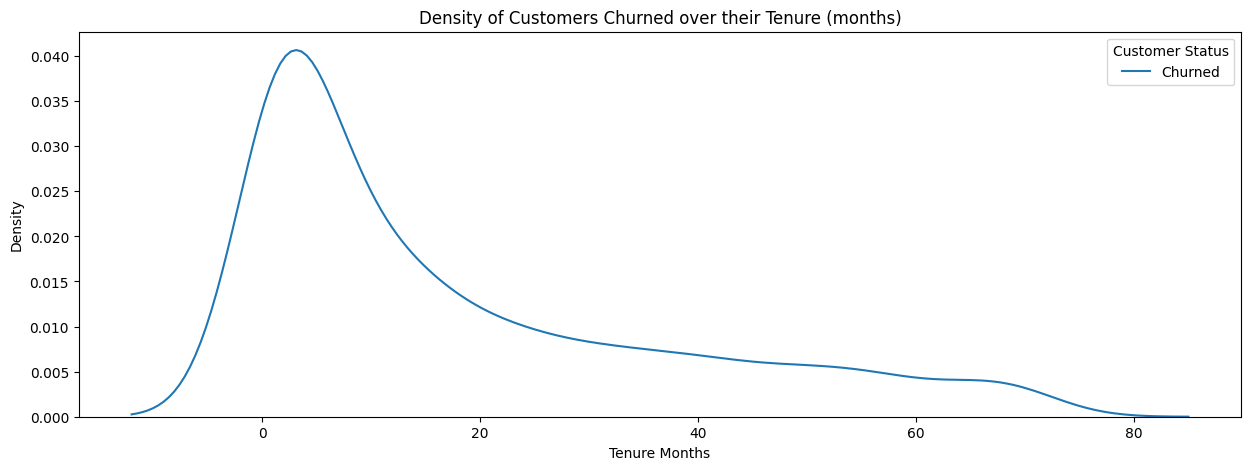

In [31]:
fig, axes = plt.subplots(figsize=(15, 5))
ax = sns.kdeplot(df[(df['Churn Label'] == 'Yes')],
                 x='Tenure Months', hue='Customer Status')
ax.set_title('Density of Customers Churned over their Tenure (months)')


Text(0.5, 1.0, 'Number of Churned Customers with Phone Service vs Tenure in Months')

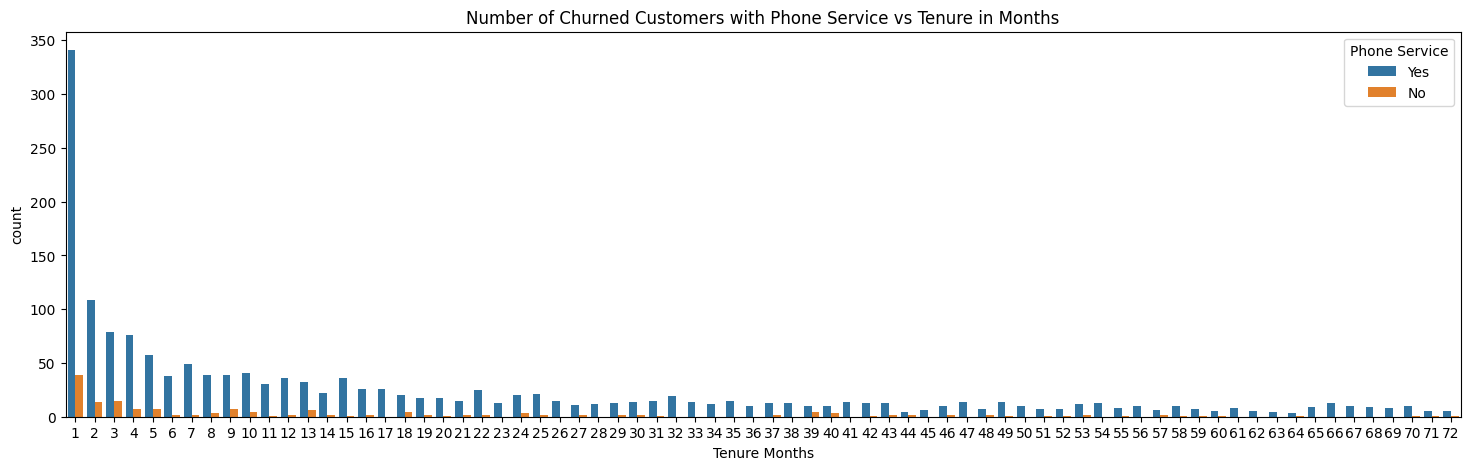

In [32]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Tenure Months', hue='Phone Service')
ax.set_title(
    'Number of Churned Customers with Phone Service vs Tenure in Months')


Text(0.5, 1.0, 'Number of Churned Customers with Internet Service vs Tenure in Months')

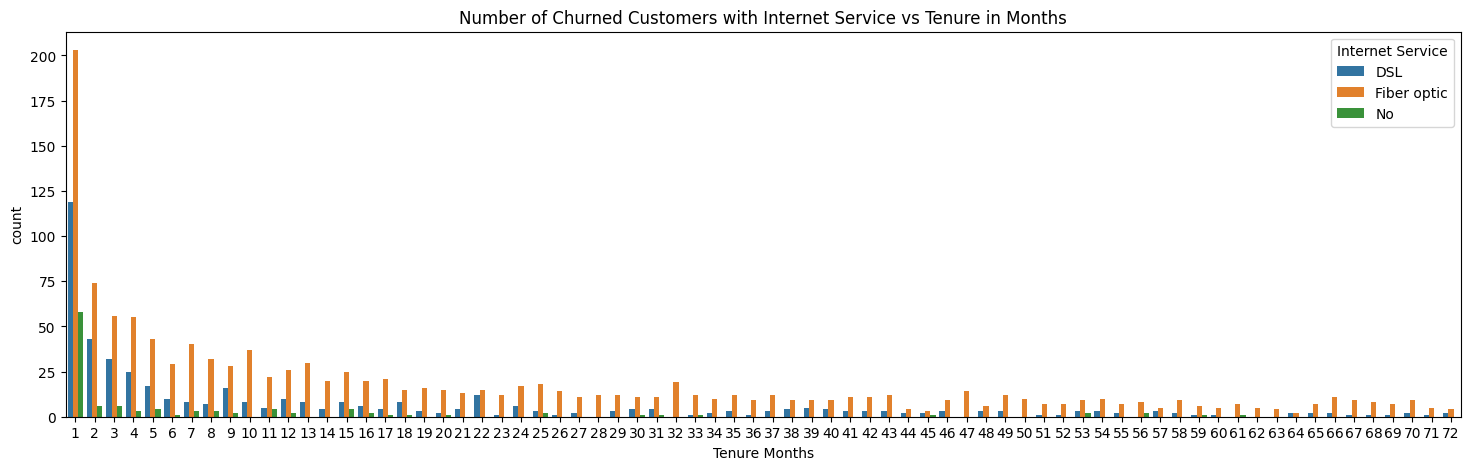

In [33]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Tenure Months', hue='Internet Service')
ax.set_title(
    'Number of Churned Customers with Internet Service vs Tenure in Months')


Text(0.5, 1.0, 'Trend of Long Distance Charges over the months')

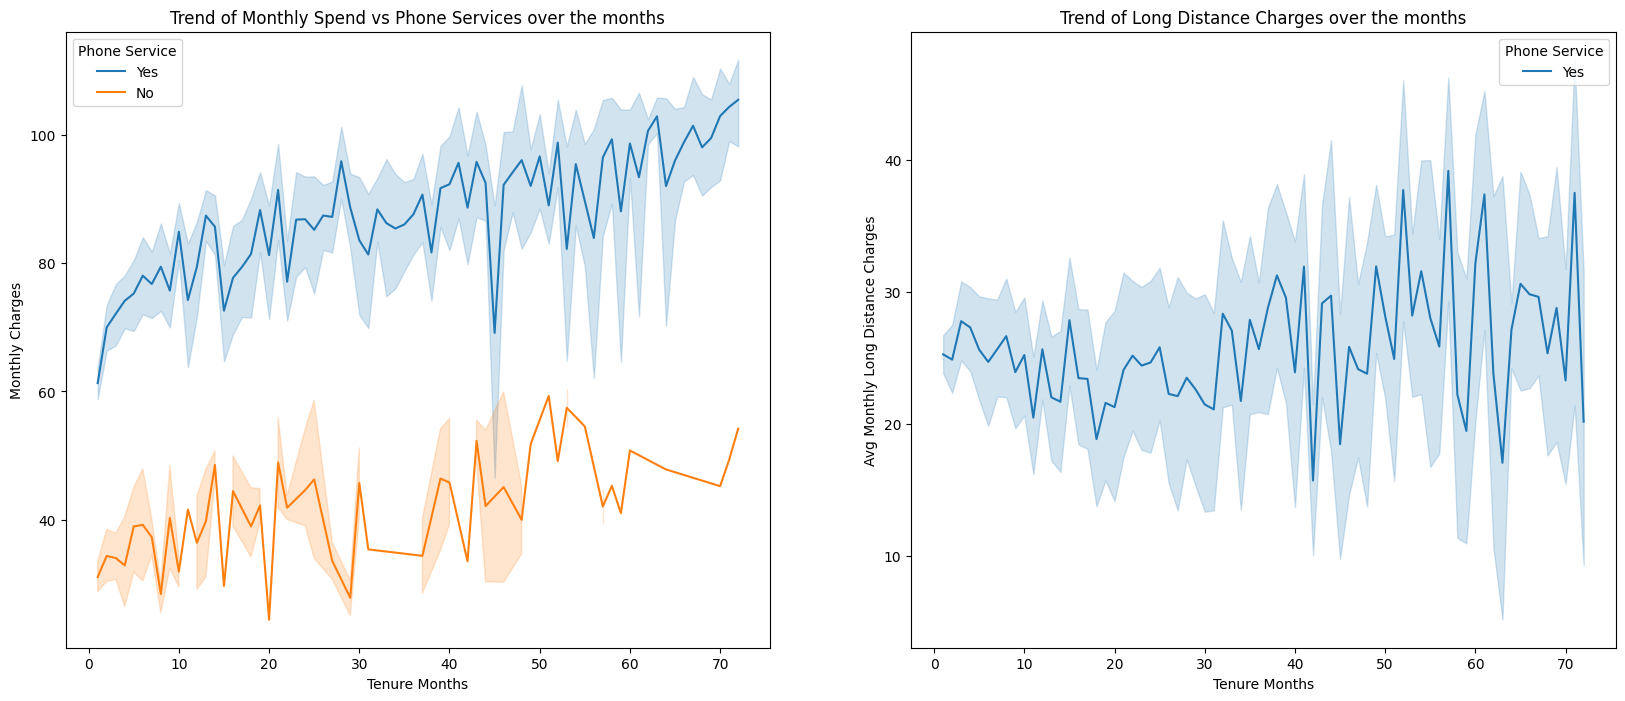

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Monthly Charges', hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Phone Services over the months')

ax = sns.lineplot(df[(df['Phone Service'] == 'Yes') & (df['Churn Label'] == 'Yes')],
                  x='Tenure Months', y='Avg Monthly Long Distance Charges', hue='Phone Service', ax=axes[1])
ax.set_title('Trend of Long Distance Charges over the months')


Text(0.5, 1.0, 'Trend of Avg Monthly GB Downloads over the months')

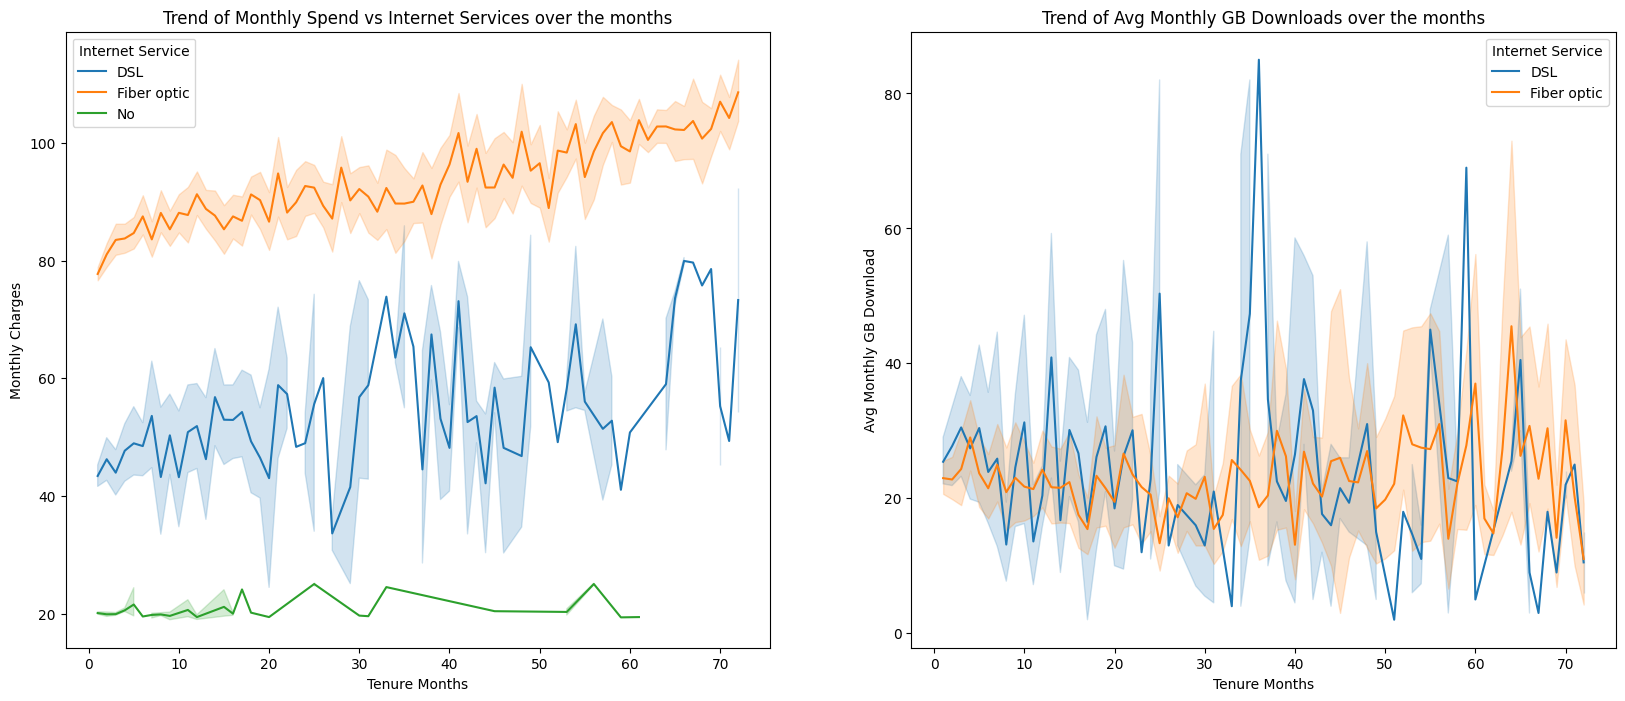

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Monthly Charges', hue='Internet Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Internet Services over the months')

ax = sns.lineplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                  x='Tenure Months', y='Avg Monthly GB Download', hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Avg Monthly GB Downloads over the months')


Text(0.5, 1.0, 'Trend of Total Spend vs Internet Services over the months')

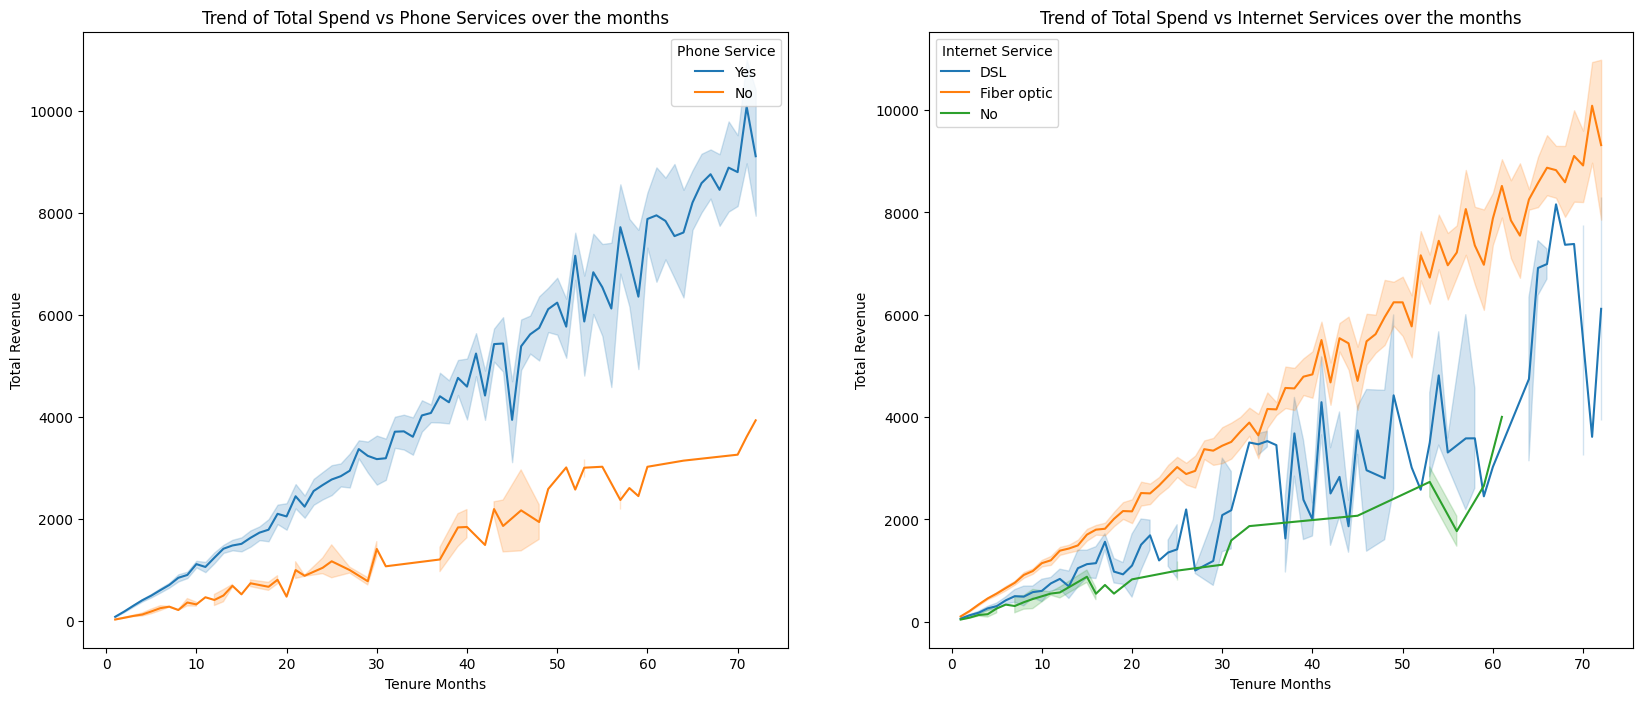

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Revenue', hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Total Spend vs Phone Services over the months')

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Revenue', hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Total Spend vs Internet Services over the months')


Text(0.5, 1.0, 'Trend of Total Extra Data Charges vs Internet Services over the months')

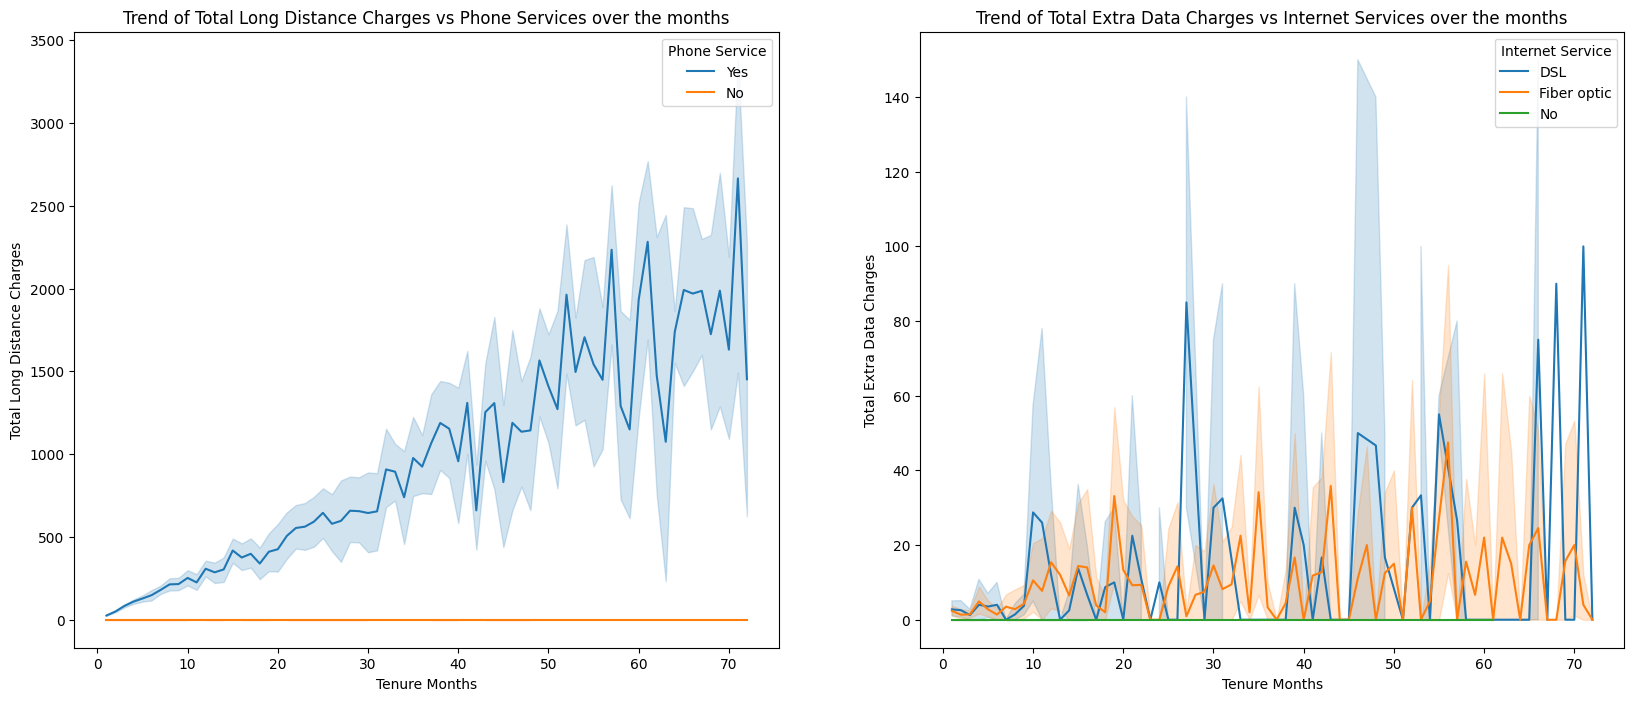

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Long Distance Charges', hue='Phone Service', ax=axes[0])
ax.set_title(
    'Trend of Total Long Distance Charges vs Phone Services over the months')

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Extra Data Charges', hue='Internet Service', ax=axes[1])
ax.set_title(
    'Trend of Total Extra Data Charges vs Internet Services over the months')


Text(0.5, 1.0, 'Avg Monthly GB Download over the Months')

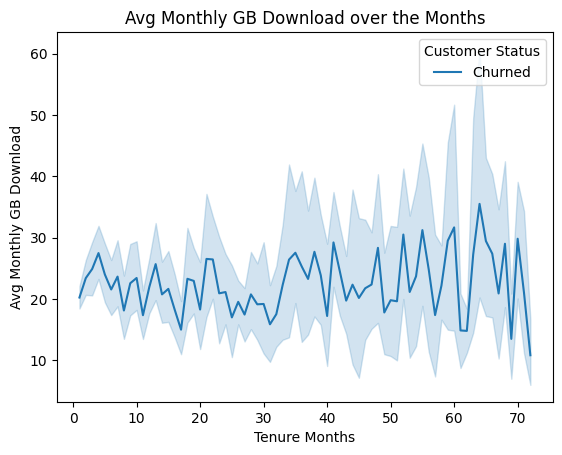

In [38]:
ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Avg Monthly GB Download', hue='Customer Status')
ax.set_title('Avg Monthly GB Download over the Months')


Text(0.5, 1.0, 'Total Refunds over the Months vs Customer Status')

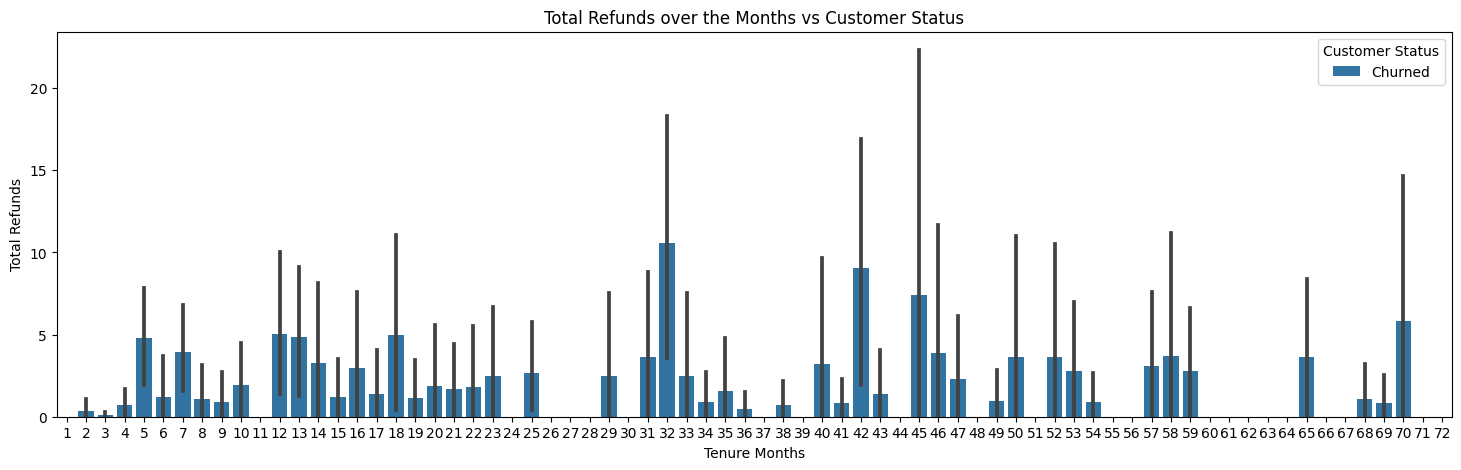

In [39]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.barplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                 y='Total Refunds', hue='Customer Status')
ax.set_title('Total Refunds over the Months vs Customer Status')


Text(0.5, 1.0, 'Number of used offers by Churned Customers')

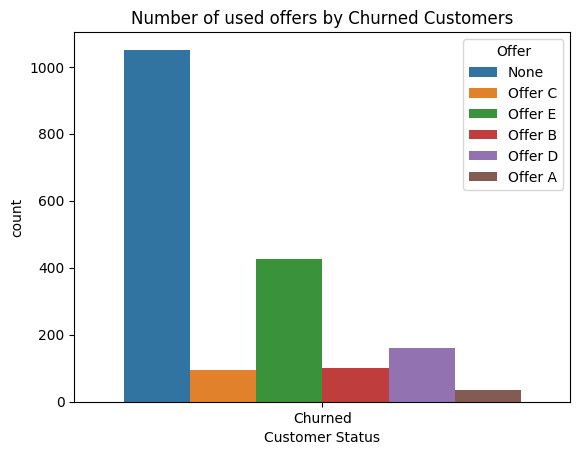

In [40]:
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Customer Status', hue='Offer')
ax.set_title('Number of used offers by Churned Customers')


Text(0.5, 1.0, 'Friend Referrals for Churned Customers')

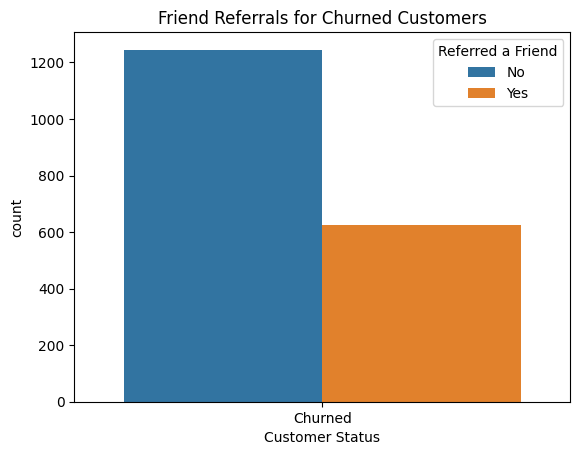

In [41]:
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Customer Status', hue='Referred a Friend')
ax.set_title('Friend Referrals for Churned Customers')


In [42]:
# cities with top churned and stayed customers
# market share per city?


# Classification

## Data Cleanup

The purpose here is to remove all unnecessary columns that would cause noise for the model.

In [43]:
df['Country'].value_counts()


United States    7043
Name: Country, Length: 1, dtype: int64

In [44]:
df['State'].value_counts()


California    7043
Name: State, Length: 1, dtype: int64

In [45]:
df['Quarter'].value_counts()


Q3    7043
Name: Quarter, Length: 1, dtype: int64

In [184]:
# drop these columns
# 'Age' is better than 'Under 30' and 'Senior Citezen'
# 'Dependents' is useless since we have 'Number of Dependents'

df.drop(['Count', 'Country', 'State', 'Quarter', 'ID', 'Lat Long', 'Customer ID',
        'Churn Label', 'Churn Category', 'Churn Reason', 'Customer Status', 'Under 30', 'Senior Citizen', 'Dependents'], axis=1, inplace=True)


In [185]:
for col in df.columns:
    print(col, df[col].dtype)


City object
Zip Code int64
Latitude float64
Longitude float64
Gender object
Partner object
Tenure Months int64
Phone Service object
Multiple Lines object
Internet Service object
Online Security object
Online Backup object
Device Protection object
Tech Support object
Streaming TV object
Streaming Movies object
Contract object
Paperless Billing object
Payment Method object
Monthly Charges float64
Total Charges object
Churn Value int64
Churn Score int64
CLTV int64
Age int64
Married object
Number of Dependents int64
Avg Monthly GB Download int64
Avg Monthly Long Distance Charges float64
Device Protection Plan object
Internet Type object
Monthly Charge float64
Number of Referrals int64
Offer object
Premium Tech Support object
Referred a Friend object
Streaming Music object
Tenure in Months int64
Total Extra Data Charges int64
Total Long Distance Charges float64
Total Refunds float64
Total Revenue float64
Unlimited Data object
Satisfaction Score int64
Population int64


In [186]:
df.columns[df.isna().any()].tolist()


[]

In [187]:
# The 'Total Charges' column contains an empty whitespace in one of the cells
# We replace it with a string zero
df['Total Charges'] = df['Total Charges'].replace({' ': 0.0})

# Replace NaN in 'Churn Reason' and 'Churn Category' with 'Not Available'
# df['Churn Reason'].fillna('Not Available', inplace=True)
# df['Churn Category'].fillna('Not Available', inplace=True)


## Categorical Data Encoding

In [188]:
# encode the categorical data
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df[cat_cols] = oe.fit_transform(df[cat_cols])
df.head(3)

# df[cat_cols].dtypes


['City', 'Gender', 'Partner', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Married', 'Device Protection Plan', 'Internet Type', 'Offer', 'Premium Tech Support', 'Referred a Friend', 'Streaming Music', 'Unlimited Data']


City  Zip Code   Latitude   Longitude  Gender  Partner  Tenure Months  \
0  562.0     90003  33.964131 -118.272783     1.0      0.0              2   
1  562.0     90003  33.964131 -118.272783     1.0      1.0              1   
2  562.0     90003  33.964131 -118.272783     0.0      1.0              3   

   Phone Service  Multiple Lines  Internet Service  Online Security  \
0            1.0             0.0               0.0              2.0   
1            1.0             0.0               2.0              1.0   
2            1.0             0.0               1.0              0.0   

   Online Backup  Device Protection  Tech Support  Streaming TV  \
0            2.0                0.0           0.0           0.0   
1            1.0                1.0           1.0           1.0   
2            2.0                0.0           2.0           0.0   

   Streaming Movies  Contract  Paperless Billing  Payment Method  \
0               0.0       0.0                1.0             3.0   
1               1.0       1.0                0.0             3.0   
2               0.0       0.0                1.0             2.0   

   Monthly Charges  Total Charges  Churn Value  Churn Score  CLTV  Age  \
0            53.85         108.15            1           86  3239   37   
1            18.80          18.80            0           51  5160   29   
2            80.00         241.30            0           76  4264   49   

   Married  Number of Dependents  Avg Monthly GB Download  \
0      0.0                     0                       21   
1      1.0                     0                        0   
2      1.0                     3                       22   

   Avg Monthly Long Distance Charges  Device Protection Plan  Internet Type  \
0                              10.47                     0.0            1.0   
1                              43.57                     0.0            3.0   
2                              19.18                     0.0            2.0   

   Monthly Charge  Number of Referrals  Offer  Premium Tech Support  \
0           53.85                    0    0.0                   0.0   
1           18.80                    9    0.0                   0.0   
2           80.00                    2    0.0                   1.0   

   Referred a Friend  Streaming Music  Tenure in Months  \
0                0.0              0.0                 2   
1                1.0              0.0                 1   
2                1.0              0.0                 3   

   Total Extra Data Charges  Total Long Distance Charges  Total Refunds  \
0                         0                        20.94            0.0   
1                         0                        43.57            0.0   
2                         0                        57.54            0.0   

   Total Revenue  Unlimited Data  Satisfaction Score  Population  
0         129.09             1.0                   1       58198  
1          62.37             0.0                   3       58198  
2         298.84             1.0                   3       58198  

[3 rows x 45 columns]

In [189]:
oe.categories_

[array(['Acampo', 'Acton', 'Adelanto', ..., 'Yucaipa', 'Yucca Valley',
        'Zenia'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['C

## Data Split

In [190]:
x = df.drop('Churn Value', axis=1)
y = df['Churn Value']


In [191]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=1)


## Model Building

In [192]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
class ClassifierModels():
    def __init__(self, df, x, y, x_test, y_test):
        '''Init function. Make sure to pass x_train and y_train here.'''

        self.df = df
        self.x = x
        self.y = y
        self.x_test = x_test
        self.y_test = y_test
        
        print('Loading dataframe...')
        print('Getting best parameters to create our models...')

        # hold abbreviations and full names
        self.model_abr = {'lr': 'Logistic Regression', 'knn': 'KNeighbors Classifier', 'svm': 'Support Vector Machine',
                          'dtc': 'Decision Tree Classifier', 'rfc': 'Random Forest Classifier', 'ensemble': 'Voting Classifier', 'xgb': 'XGB Classifier'}

        # hold the actual models
        self.models = {}
        self.model_predicts = {}
        self.model_predicts_proba = {}

        # loop over the models dict to get each model's best params
        for model in self.model_abr:
            print('+++ {} +++'.format(self.model_abr[model]))
            params = self.get_best_params(model)

            print('Best parameters for the {} model: {}'.format(
                self.model_abr[model], params))
            print('Creating and fitting the {} model using its best parameters...'.format(
                self.model_abr[model]))

            if model == 'lr':
                m = LogisticRegression(
                    solver=params['solver'], penalty=params['penalty'], C=params['C'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'knn':
                m = KNeighborsClassifier(
                    n_neighbors=params['n_neighbors'], weights=params['weights'], metric=params['metric'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'svm':
                m = SVC(kernel=params['kernel'],
                        C=params['C'], gamma=params['gamma'], probability=True)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'dtc':
                m = DecisionTreeClassifier(
                    criterion=params['criterion'], splitter=params['splitter'], max_features=params['max_features'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'rfc':
                m = RandomForestClassifier(
                    n_estimators=params['n_estimators'], max_features=params['max_features'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'ensemble':
                # weights = np.random.random_integers(1, 10, (10, 5)).tolist()
                m = VotingClassifier(estimators=[('Logistic Regression', self.models['lr']), ('Decission Tree Classifier', self.models['dtc']), (
                    'Random Forrest Classifier', self.models['rfc']), ('KNN', self.models['knn']), ('SVM', self.models['svm'])], weights=[10, 10, 10, 10, 10], voting='soft')
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'xgb':
                m = XGBClassifier()
                m.fit(self.x, self.y)

                self.models[model] = m

        print('All models created and fitted successfully!')
        print('------------')

        # loop over the models and get the y_pred
        for model in self.model_abr:
            y_pred = self.models[model].predict(self.x_test)

            self.model_predicts[model] = y_pred

        # loop over the models and get the y_pred_proba
        for model in self.model_abr:
            y_pred_proba = self.models[model].predict_proba(self.x_test)

            self.model_predicts_proba[model] = y_pred_proba

    @ignore_warnings(category=ConvergenceWarning)
    def get_best_params(self, model):
        '''This method returns the best params for hypertuning each model'''

        if model == 'lr':
            # model
            lr_model = LogisticRegression()

            # params
            solver = ['newton-cg', 'lbfgs', 'liblinear']
            penalty = ['l2']
            C = [100, 10, 1.0, 0.1, 0.01]
            lr_params = dict(solver=solver, penalty=penalty, C=C)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            lr_gsearch = GridSearchCV(estimator=lr_model, param_grid=lr_params,
                                      cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            lr_gresult = lr_gsearch.fit(self.x, self.y)

            return lr_gresult.best_params_

        elif model == 'knn':
            # model
            knn_model = KNeighborsClassifier()

            # params
            n_neighbors = range(1, 31, 2)
            weights = ['uniform', 'distance']
            metric = ['euclidean', 'manhattan', 'minkowski']
            knn_params = dict(n_neighbors=n_neighbors,
                              weights=weights, metric=metric)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            knn_gsearch = GridSearchCV(estimator=knn_model, param_grid=knn_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            knn_gresult = knn_gsearch.fit(self.x, self.y)

            return knn_gresult.best_params_

        elif model == 'svm':
            # model
            svm_model = SVC()

            # params
            kernel = ['poly', 'rbf', 'sigmoid']
            C = [50, 10, 1.0, 0.1, 0.01]
            gamma = ['scale']
            svm_params = dict(kernel=kernel, C=C, gamma=gamma)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            svm_gsearch = GridSearchCV(estimator=svm_model, param_grid=svm_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            svm_gresult = svm_gsearch.fit(self.x, self.y)

            return svm_gresult.best_params_

        elif model == 'dtc':
            # model
            dtc_model = DecisionTreeClassifier()

            # params
            criterion = ['gini', 'entropy', 'log_loss']
            splitter = ['best', 'random']
            max_features = ['sqrt', 'log2', None]
            dtc_params = dict(criterion=criterion,
                              splitter=splitter, max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            dtc_gsearch = GridSearchCV(estimator=dtc_model, param_grid=dtc_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            dtc_gresult = dtc_gsearch.fit(self.x, self.y)

            return dtc_gresult.best_params_

        elif model == 'rfc':
            # model
            rfc_model = RandomForestClassifier()

            # params
            n_estimators = [10, 100, 1000]
            max_features = ['sqrt', 'log2']
            rfc_params = dict(n_estimators=n_estimators,
                              max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            rfc_gsearch = GridSearchCV(estimator=rfc_model, param_grid=rfc_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            rfc_gresult = rfc_gsearch.fit(self.x, self.y)

            return rfc_gresult.best_params_

        elif model == 'ensemble':
            return

        elif model == 'xgb':
            return

        else:
            raise NameError(
                'No grid search model available for {}.'.format(model))

    def show_performance(self):
        '''This method prints the accuracy, precision, recall, and f1 score for each model.'''

        headers = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        tbldata = []
        for model in self.models:
            accuracy = metrics.accuracy_score(
                self.y_test, self.model_predicts[model])
            f1score = metrics.f1_score(self.y_test, self.model_predicts[model])
            precision = metrics.precision_score(
                self.y_test, self.model_predicts[model])
            recall = metrics.recall_score(
                self.y_test, self.model_predicts[model])

            tbldata.append([self.model_abr[model], accuracy, precision, recall, f1score])
            # print('{} model performance:'.format(self.model_abr[model]))
            # print(f'+++ Accuracy = {100 * accuracy:.3}')
            # print(f'+++ Precision = {100 * precision:.3}')
            # print(f'+++ Recall = {100 * recall:.3}')
            # print(f'+++ F1 score = {100 * f1score:.3}')

        return tabulate(tbldata, headers=headers, tablefmt="pretty")

    def show_roc_curve(self):
        '''This function calculates the True and False positive rates for all models and plots them on a single graph.'''

        roc_results = {}
        for model in self.model_abr:
            std_fpr, std_tpr, std_thresholds = roc_curve(
                self.y_test, self.model_predicts_proba[model][:, 1])

            roc_results[model] = [std_fpr, std_tpr, std_thresholds]

        ax.plot([0, 1], [1, 0], 'k--')
        for model in roc_results:
            ax.plot(roc_results[model][0],
                    roc_results[model][1], c=np.random.rand(3,))
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

        ax.legend([self.model_abr[m]
                  for m in self.model_abr], loc="lower right")
        ax.set_title('ROC Curve for Hypertuned Models')

        plt.show()


In [193]:
cm = ClassifierModels(df, x_train, y_train, x_test, y_test)

Loading dataframe...
Getting best parameters to create our models...
+++ Logistic Regression +++


/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Best parameters for the Logistic Regression model: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Creating and fitting the Logistic Regression model using its best parameters...
+++ KNeighbors Classifier +++
Best parameters for the KNeighbors Classifier model: {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}
Creating and fitting the KNeighbors Classifier model using its best parameters...
+++ Support Vector Machine +++
Best parameters for the Support Vector Machine model: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
Creating and fitting the Support Vector Machine model using its best parameters...
+++ Decision Tree Classifier +++
Best parameters for the Decision Tree Classifier model: {'criterion': 'log_loss', 'max_features': None, 'splitter': 'best'}
Creating and fitting the Decision Tree Classifier model using its best parameters...
+++ Random Forest Classifier +++
Best parameters for the Random Forest Classifier model: {'max_features': 'sqrt', 'n_estimators': 10

In [194]:
for m in cm.models:
    print(m, cm.models[m])


lr LogisticRegression(solver='newton-cg')
knn KNeighborsClassifier(metric='manhattan', n_neighbors=27)
svm SVC(C=50, kernel='poly', probability=True)
dtc DecisionTreeClassifier(criterion='log_loss')
rfc RandomForestClassifier(n_estimators=1000)
ensemble VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(solver='newton-cg')),
                             ('Decission Tree Classifier',
                              DecisionTreeClassifier(criterion='log_loss')),
                             ('Random Forrest Classifier',
                              RandomForestClassifier(n_estimators=1000)),
                             ('KNN',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=27)),
                             ('SVM',
                              SVC(C=50, kernel='poly', probability=True))],
                 voting='soft', weights=[10, 10, 10, 10, 10])
x

## Model Performance

In [195]:
print(cm.show_performance())

+--------------------------+--------------------+--------------------+--------------------+--------------------+
|                          |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|   Logistic Regression    | 0.9777567439659253 | 0.9611829944547134 | 0.9523809523809523 | 0.9567617295308187 |
|  KNeighbors Classifier   | 0.7434926644581165 | 0.5140845070422535 | 0.1336996336996337 | 0.2122093023255814 |
|  Support Vector Machine  | 0.7415996213913867 |        0.0         |        0.0         |        0.0         |
| Decision Tree Classifier | 0.9768102224325603 | 0.9509981851179673 | 0.9597069597069597 | 0.9553327256153145 |
| Random Forest Classifier | 0.9791765262659725 | 0.9771863117870723 | 0.9413919413919414 | 0.9589552238805971 |
|    Voting Classifier     | 0.9801230477993375 | 0.9684014869888475 | 0.9542124542124543 | 0.96

## ROC

Text(0.5, 1.0, 'ROC Curve for Models')

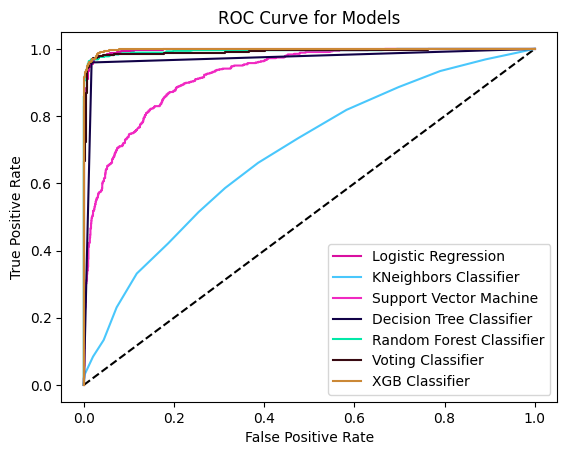

In [196]:
roc_results = {}
for model in cm.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm.y_test, cm.model_predicts_proba[model][:, 1])

    roc_results[model] = [fpr, tpr, thresholds]

plt.plot([0, 1], [0, 1], 'k--')
for model in roc_results:
    plt.plot(roc_results[model][0],
            roc_results[model][1], c=np.random.rand(3,), label=cm.model_abr[model])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC Curve for Models')

## AUC

In [197]:
headers = ['AUC']
tbldata = []

for m in cm.model_abr:
    auc = roc_auc_score(cm.y_test, cm.model_predicts_proba[m][:, 1])

    tbldata.append([cm.model_abr[m], auc])

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))

+--------------------------+--------------------+
|                          |        AUC         |
+--------------------------+--------------------+
|   Logistic Regression    | 0.9967951639936323 |
|  KNeighbors Classifier   | 0.6880217208870688 |
|  Support Vector Machine  | 0.9236344383121664 |
| Decision Tree Classifier | 0.9712382915956624 |
| Random Forest Classifier | 0.9944616646914031 |
|    Voting Classifier     | 0.9916454530366464 |
|      XGB Classifier      | 0.9984162827174953 |
+--------------------------+--------------------+
